# Traffic congestion and forecasting

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:

from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta, date
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [4]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [5]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.initializers import he_normal
import keras.backend as K

In [6]:
import warnings
warnings.filterwarnings("ignore")

## Importing Data and exploration

In [7]:
data=pd.read_csv("/kaggle/input/traffic-prediction-dataset/traffic.csv")

In [8]:
data

DateTime  Junction  Vehicles           ID
0      2015-11-01 00:00:00         1        15  20151101001
1      2015-11-01 01:00:00         1        13  20151101011
2      2015-11-01 02:00:00         1        10  20151101021
3      2015-11-01 03:00:00         1         7  20151101031
4      2015-11-01 04:00:00         1         9  20151101041
...                    ...       ...       ...          ...
48115  2017-06-30 19:00:00         4        11  20170630194
48116  2017-06-30 20:00:00         4        30  20170630204
48117  2017-06-30 21:00:00         4        16  20170630214
48118  2017-06-30 22:00:00         4        22  20170630224
48119  2017-06-30 23:00:00         4        12  20170630234

[48120 rows x 4 columns]

In [9]:
data.shape

(48120, 4)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


DateTime data type is not in correct format so we will change its dtype

In [11]:
data['DateTime'] = pd.to_datetime(data['DateTime'])

In [12]:
data

DateTime  Junction  Vehicles           ID
0     2015-11-01 00:00:00         1        15  20151101001
1     2015-11-01 01:00:00         1        13  20151101011
2     2015-11-01 02:00:00         1        10  20151101021
3     2015-11-01 03:00:00         1         7  20151101031
4     2015-11-01 04:00:00         1         9  20151101041
...                   ...       ...       ...          ...
48115 2017-06-30 19:00:00         4        11  20170630194
48116 2017-06-30 20:00:00         4        30  20170630204
48117 2017-06-30 21:00:00         4        16  20170630214
48118 2017-06-30 22:00:00         4        22  20170630224
48119 2017-06-30 23:00:00         4        12  20170630234

[48120 rows x 4 columns]

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB


In [14]:
data.isna().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

No Missing data 

In [15]:
#Extracting year,month,day and hour from DateTime
data['Year']=data['DateTime'].dt.year
data['Month']=data['DateTime'].dt.month
data['Day']=data['DateTime'].dt.day
data['hour']=data['DateTime'].dt.hour

In [16]:
data

DateTime  Junction  Vehicles           ID  Year  Month  Day  \
0     2015-11-01 00:00:00         1        15  20151101001  2015     11    1   
1     2015-11-01 01:00:00         1        13  20151101011  2015     11    1   
2     2015-11-01 02:00:00         1        10  20151101021  2015     11    1   
3     2015-11-01 03:00:00         1         7  20151101031  2015     11    1   
4     2015-11-01 04:00:00         1         9  20151101041  2015     11    1   
...                   ...       ...       ...          ...   ...    ...  ...   
48115 2017-06-30 19:00:00         4        11  20170630194  2017      6   30   
48116 2017-06-30 20:00:00         4        30  20170630204  2017      6   30   
48117 2017-06-30 21:00:00         4        16  20170630214  2017      6   30   
48118 2017-06-30 22:00:00         4        22  20170630224  2017      6   30   
48119 2017-06-30 23:00:00         4        12  20170630234  2017      6   30   

       hour  
0         0  
1         1  
2         2  
3         3  
4         4  
...     ...  
48115    19  
48116    20  
48117    21  
48118    22  
48119    23  

[48120 rows x 8 columns]

In [17]:
data.columns

Index(['DateTime', 'Junction', 'Vehicles', 'ID', 'Year', 'Month', 'Day',
       'hour'],
      dtype='object')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
 4   Year      48120 non-null  int64         
 5   Month     48120 non-null  int64         
 6   Day       48120 non-null  int64         
 7   hour      48120 non-null  int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 2.9 MB


In [19]:
#Statistical Analysis
data.describe().T

count          mean           std           min           25%  \
Junction  48120.0  2.180549e+00  9.669554e-01  1.000000e+00  1.000000e+00   
Vehicles  48120.0  2.279133e+01  2.075006e+01  1.000000e+00  9.000000e+00   
ID        48120.0  2.016330e+10  5.944854e+06  2.015110e+10  2.016042e+10   
Year      48120.0  2.016270e+03  6.160935e-01  2.015000e+03  2.016000e+03   
Month     48120.0  5.884289e+00  3.569872e+00  1.000000e+00  3.000000e+00   
Day       48120.0  1.570075e+01  8.784073e+00  1.000000e+00  8.000000e+00   
hour      48120.0  1.150000e+01  6.922258e+00  0.000000e+00  5.750000e+00   

                   50%           75%           max  
Junction  2.000000e+00  3.000000e+00  4.000000e+00  
Vehicles  1.500000e+01  2.900000e+01  1.800000e+02  
ID        2.016093e+10  2.017023e+10  2.017063e+10  
Year      2.016000e+03  2.017000e+03  2.017000e+03  
Month     5.000000e+00  9.000000e+00  1.200000e+01  
Day       1.600000e+01  2.300000e+01  3.100000e+01  
hour      1.150000e+01  1.725000e+01  2.300000e+01

In [20]:
#colum ID is not impacting data hence we can drop it
data.drop('ID',axis=1,inplace=True)
data

DateTime  Junction  Vehicles  Year  Month  Day  hour
0     2015-11-01 00:00:00         1        15  2015     11    1     0
1     2015-11-01 01:00:00         1        13  2015     11    1     1
2     2015-11-01 02:00:00         1        10  2015     11    1     2
3     2015-11-01 03:00:00         1         7  2015     11    1     3
4     2015-11-01 04:00:00         1         9  2015     11    1     4
...                   ...       ...       ...   ...    ...  ...   ...
48115 2017-06-30 19:00:00         4        11  2017      6   30    19
48116 2017-06-30 20:00:00         4        30  2017      6   30    20
48117 2017-06-30 21:00:00         4        16  2017      6   30    21
48118 2017-06-30 22:00:00         4        22  2017      6   30    22
48119 2017-06-30 23:00:00         4        12  2017      6   30    23

[48120 rows x 7 columns]

In [21]:
data['Junction'].value_counts()

1    14592
2    14592
3    14592
4     4344
Name: Junction, dtype: int64

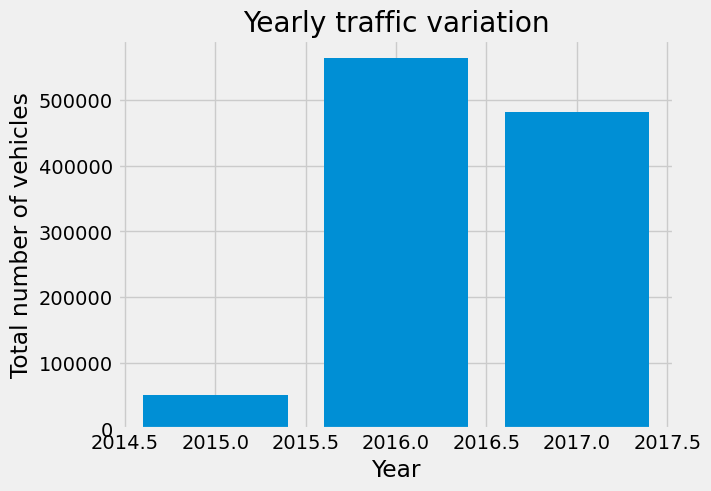

In [22]:
# group the data by year and calculate the total number of vehicles for each year
yearly_data = data.groupby(['Year'])['Vehicles'].sum()

# plot the data using matplotlib
plt.bar(yearly_data.index, yearly_data.values)
plt.xlabel('Year')
plt.ylabel('Total number of vehicles')
plt.title('Yearly traffic variation')
plt.show()

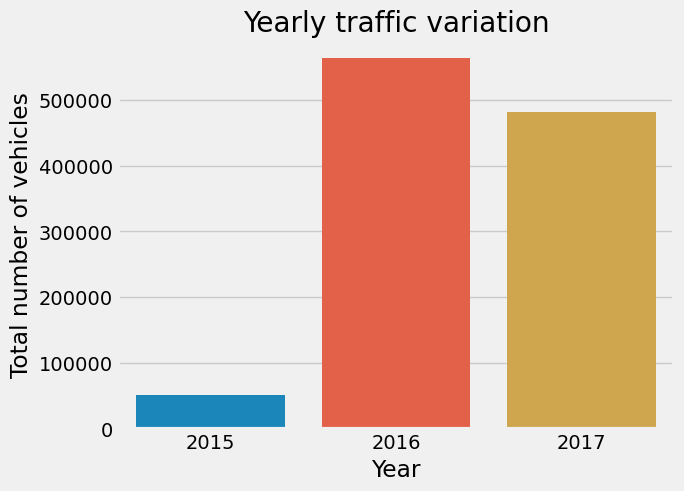

In [23]:
sns.barplot(x=yearly_data.index, y=yearly_data.values)
plt.xlabel('Year')
plt.ylabel('Total number of vehicles')
plt.title('Yearly traffic variation')
plt.show()

### Creating function to plot distribution and time series plot wrt different Junction

In [24]:
def junction_data(junction=1):
    data_jun=data[data['Junction']==junction]
    fig, ax = plt.subplots(figsize=(17, 5))
    ax = sns.histplot(data_jun['Vehicles'], kde=True)
    ax.set_title(f'Plot show the distribution of data in junction {junction}')
    ax.grid(True, ls='-.', alpha=0.75)
    plt.show()
    return data_jun

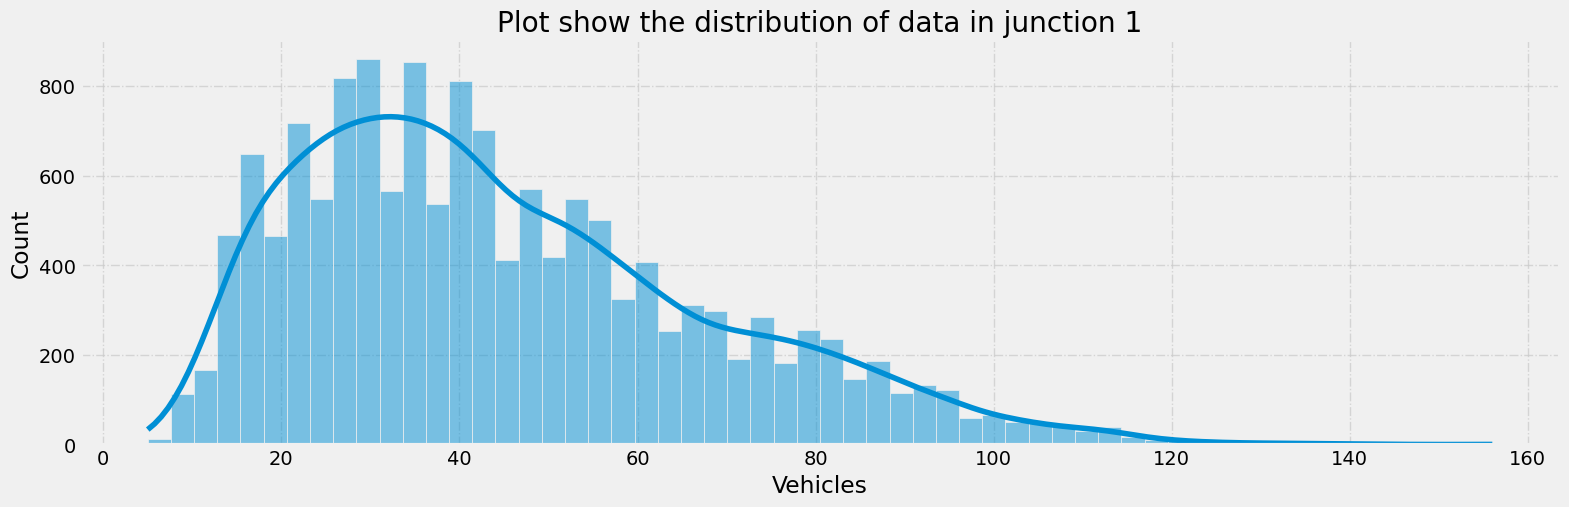

DateTime  Junction  Vehicles  Year  Month  Day  hour
0     2015-11-01 00:00:00         1        15  2015     11    1     0
1     2015-11-01 01:00:00         1        13  2015     11    1     1
2     2015-11-01 02:00:00         1        10  2015     11    1     2
3     2015-11-01 03:00:00         1         7  2015     11    1     3
4     2015-11-01 04:00:00         1         9  2015     11    1     4
...                   ...       ...       ...   ...    ...  ...   ...
14587 2017-06-30 19:00:00         1       105  2017      6   30    19
14588 2017-06-30 20:00:00         1        96  2017      6   30    20
14589 2017-06-30 21:00:00         1        90  2017      6   30    21
14590 2017-06-30 22:00:00         1        84  2017      6   30    22
14591 2017-06-30 23:00:00         1        78  2017      6   30    23

[14592 rows x 7 columns]

In [25]:
data_junc_1=junction_data(1)
data_junc_1

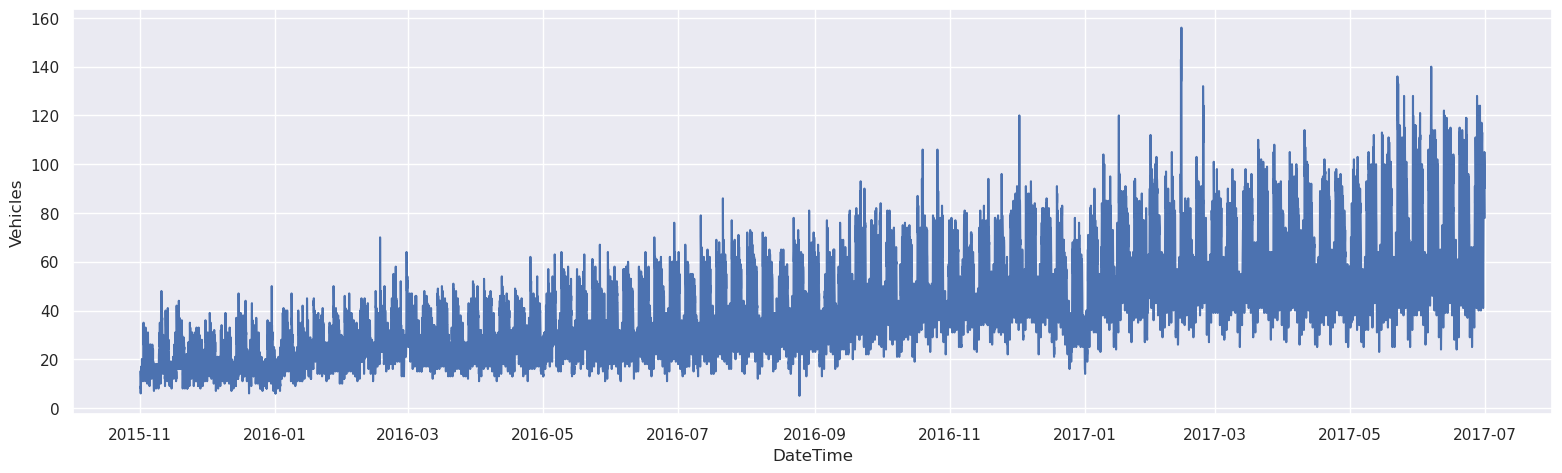

In [26]:
sns.set(rc={'figure.figsize':(17,5)})
sns.lineplot(data=data_junc_1,y='Vehicles',x='DateTime')
plt.show()

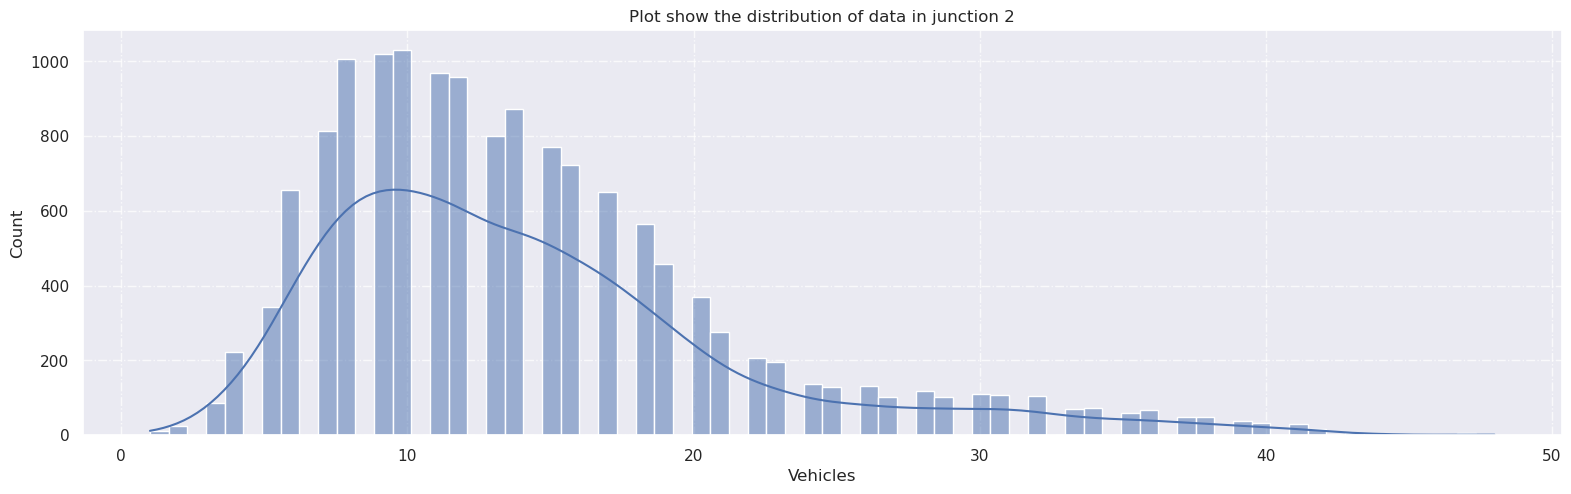

DateTime  Junction  Vehicles  Year  Month  Day  hour
14592 2015-11-01 00:00:00         2         6  2015     11    1     0
14593 2015-11-01 01:00:00         2         6  2015     11    1     1
14594 2015-11-01 02:00:00         2         5  2015     11    1     2
14595 2015-11-01 03:00:00         2         6  2015     11    1     3
14596 2015-11-01 04:00:00         2         7  2015     11    1     4
...                   ...       ...       ...   ...    ...  ...   ...
29179 2017-06-30 19:00:00         2        34  2017      6   30    19
29180 2017-06-30 20:00:00         2        35  2017      6   30    20
29181 2017-06-30 21:00:00         2        31  2017      6   30    21
29182 2017-06-30 22:00:00         2        29  2017      6   30    22
29183 2017-06-30 23:00:00         2        27  2017      6   30    23

[14592 rows x 7 columns]

In [27]:
data_junc_2=junction_data(2)
data_junc_2

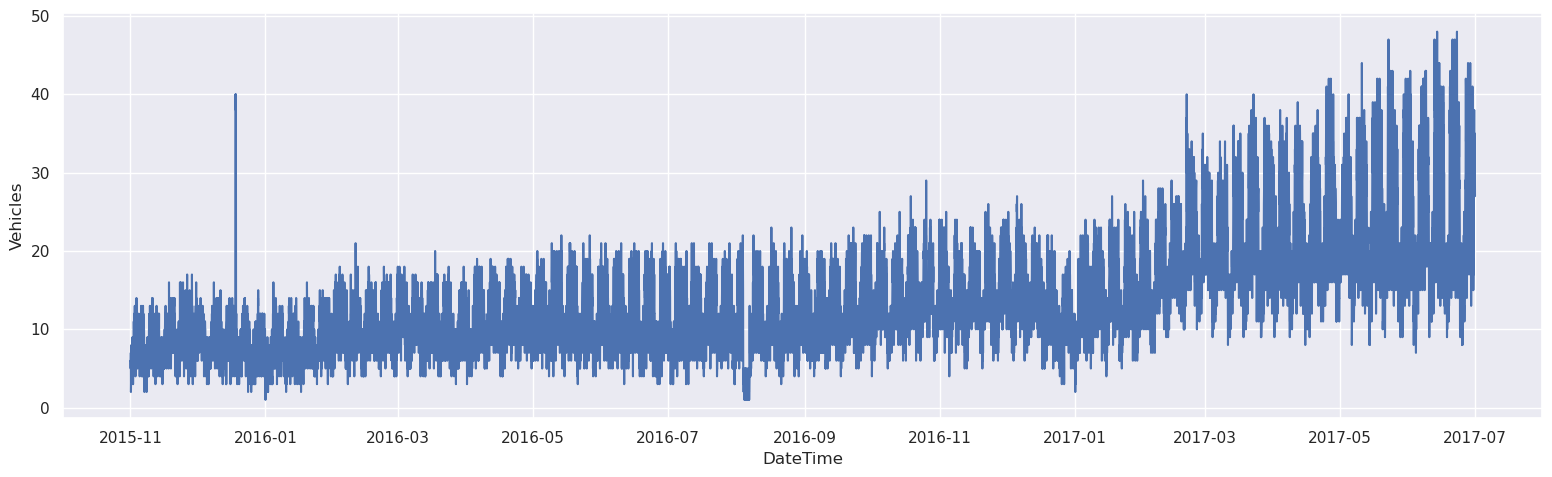

In [28]:
sns.set(rc={'figure.figsize':(17,5)})
sns.lineplot(data=data_junc_2,y='Vehicles',x='DateTime')
plt.show()

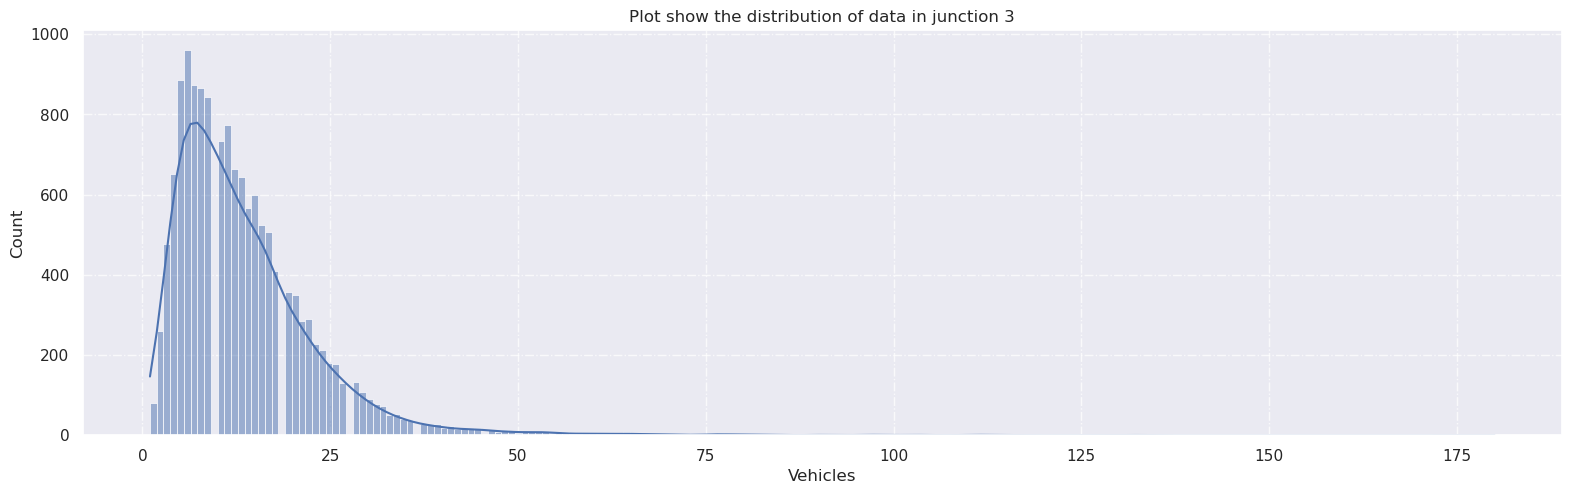

DateTime  Junction  Vehicles  Year  Month  Day  hour
29184 2015-11-01 00:00:00         3         9  2015     11    1     0
29185 2015-11-01 01:00:00         3         7  2015     11    1     1
29186 2015-11-01 02:00:00         3         5  2015     11    1     2
29187 2015-11-01 03:00:00         3         1  2015     11    1     3
29188 2015-11-01 04:00:00         3         2  2015     11    1     4
...                   ...       ...       ...   ...    ...  ...   ...
43771 2017-06-30 19:00:00         3        33  2017      6   30    19
43772 2017-06-30 20:00:00         3        31  2017      6   30    20
43773 2017-06-30 21:00:00         3        28  2017      6   30    21
43774 2017-06-30 22:00:00         3        26  2017      6   30    22
43775 2017-06-30 23:00:00         3        39  2017      6   30    23

[14592 rows x 7 columns]

In [29]:
data_junc_3=junction_data(3)
data_junc_3

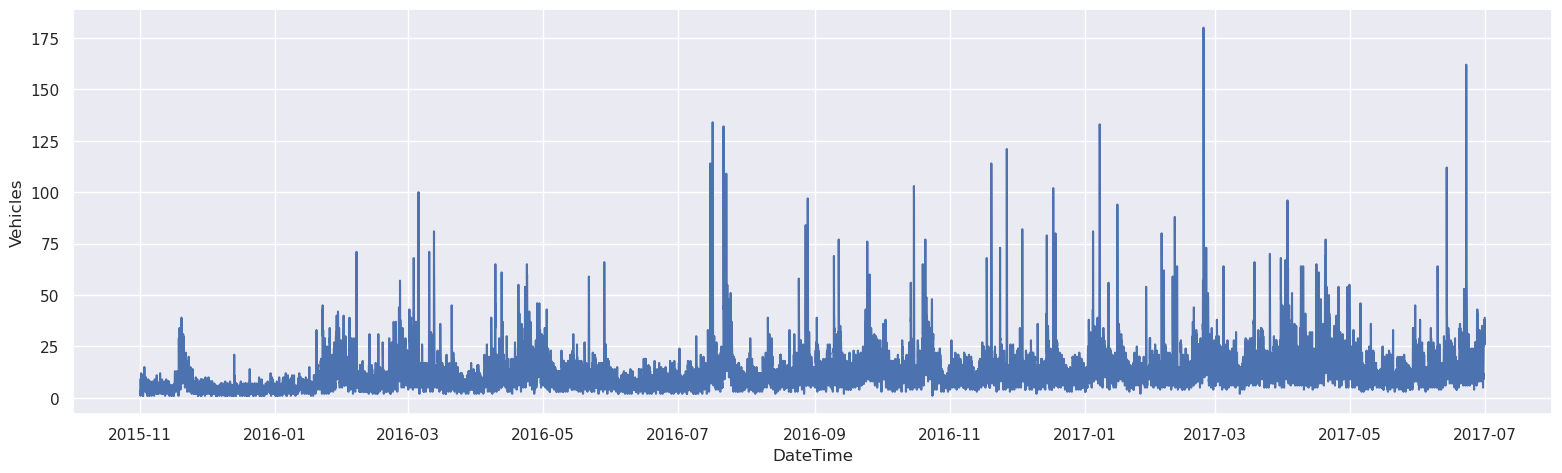

In [30]:
sns.set(rc={'figure.figsize':(17,5)})
sns.lineplot(data=data_junc_3,y='Vehicles',x='DateTime')
plt.show()

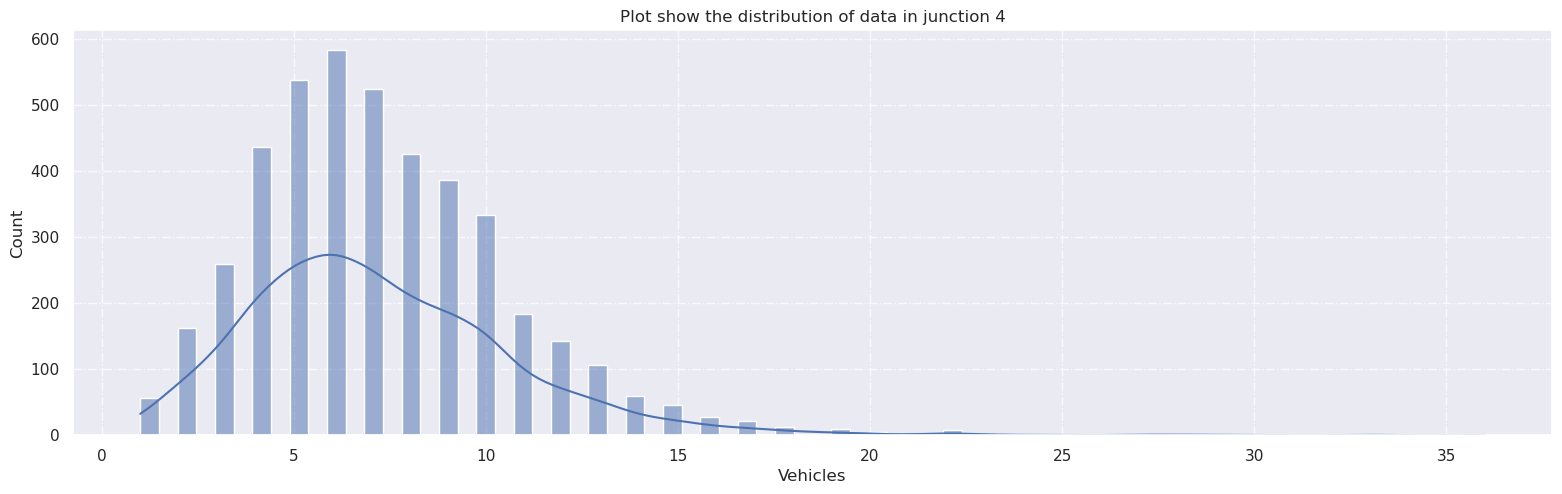

DateTime  Junction  Vehicles  Year  Month  Day  hour
43776 2017-01-01 00:00:00         4         3  2017      1    1     0
43777 2017-01-01 01:00:00         4         1  2017      1    1     1
43778 2017-01-01 02:00:00         4         4  2017      1    1     2
43779 2017-01-01 03:00:00         4         4  2017      1    1     3
43780 2017-01-01 04:00:00         4         2  2017      1    1     4
...                   ...       ...       ...   ...    ...  ...   ...
48115 2017-06-30 19:00:00         4        11  2017      6   30    19
48116 2017-06-30 20:00:00         4        30  2017      6   30    20
48117 2017-06-30 21:00:00         4        16  2017      6   30    21
48118 2017-06-30 22:00:00         4        22  2017      6   30    22
48119 2017-06-30 23:00:00         4        12  2017      6   30    23

[4344 rows x 7 columns]

In [31]:
data_junc_4=junction_data(4)
data_junc_4

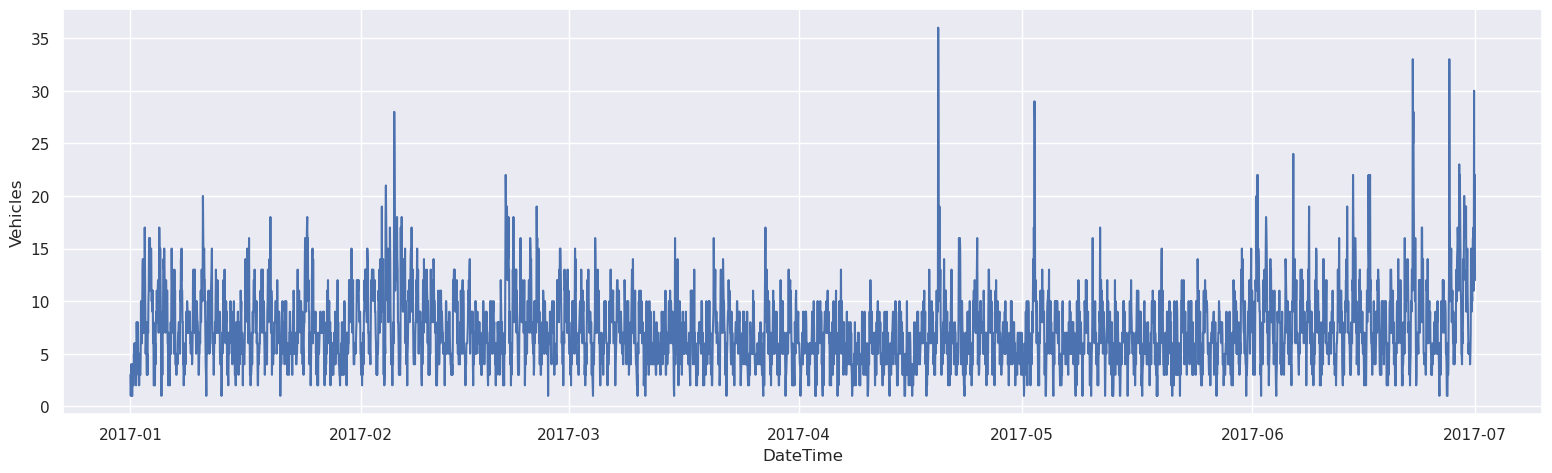

In [32]:
sns.set(rc={'figure.figsize':(17,5)})
sns.lineplot(data=data_junc_4,y='Vehicles',x='DateTime')
plt.show()

Distribution look normal but skewed

time series plot look stationary

In [33]:
def grouping_data_junc(df):
    year_grouping=df.groupby(['Year'])['Vehicles'].sum().reset_index()
    month_grouping=df.groupby(['Month'])['Vehicles'].sum().reset_index()
    day_grouping=df.groupby(['Day'])['Vehicles'].sum().reset_index()
    fig,ax=plt.subplots(1,3,figsize=(20,5))
    sns.barplot(data=year_grouping,x='Year',y='Vehicles',ax=ax[0])
    sns.barplot(data=month_grouping,x='Month',y='Vehicles',ax=ax[1])
    sns.barplot(data=day_grouping,x='Day',y='Vehicles',ax=ax[2])
    

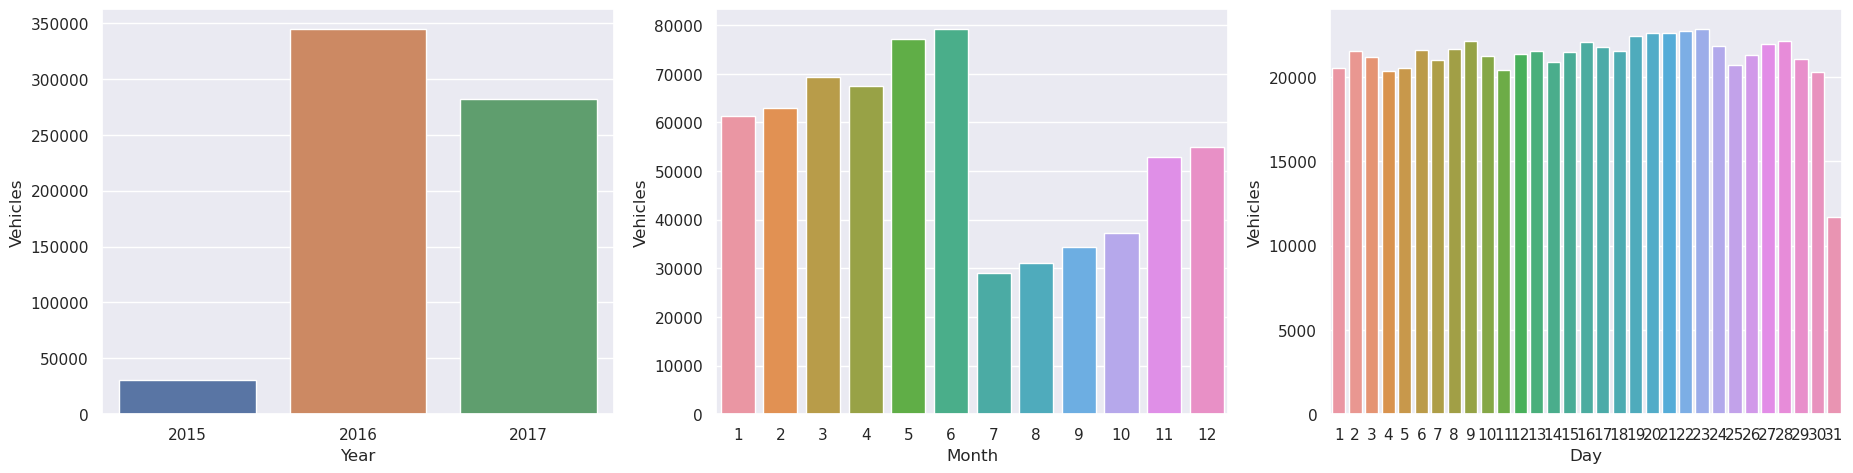

In [34]:
grouping_data_junc(data_junc_1)

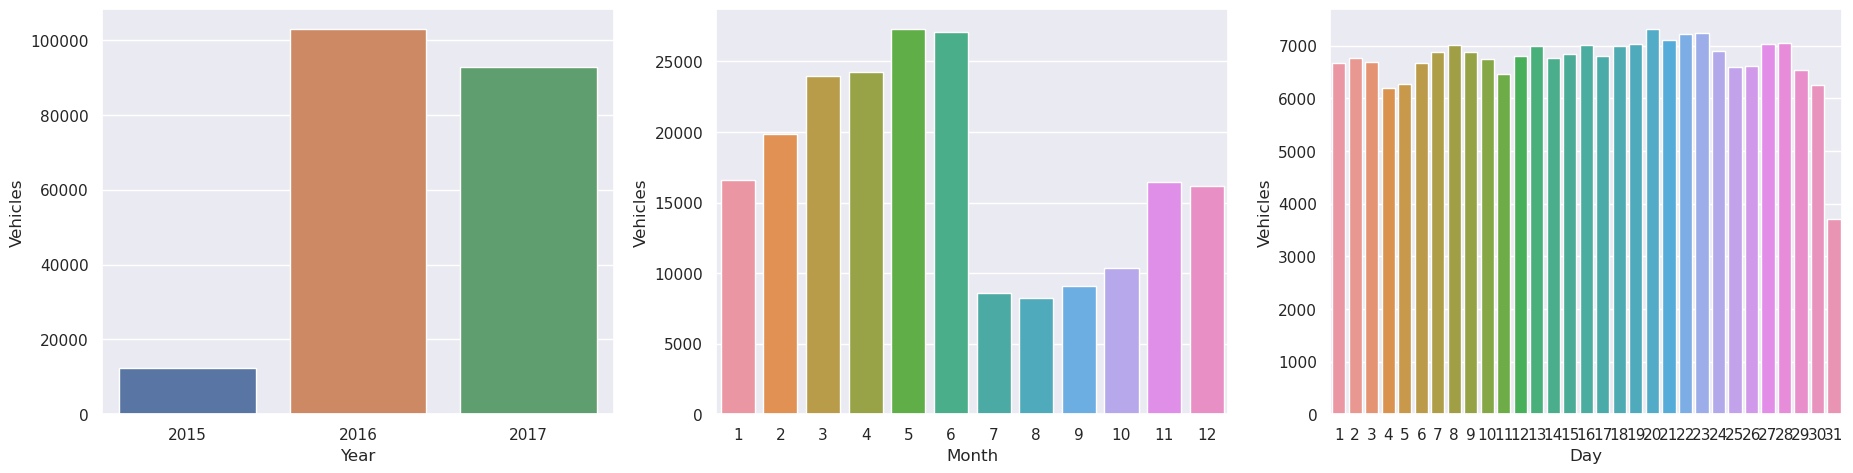

In [35]:
grouping_data_junc(data_junc_2)

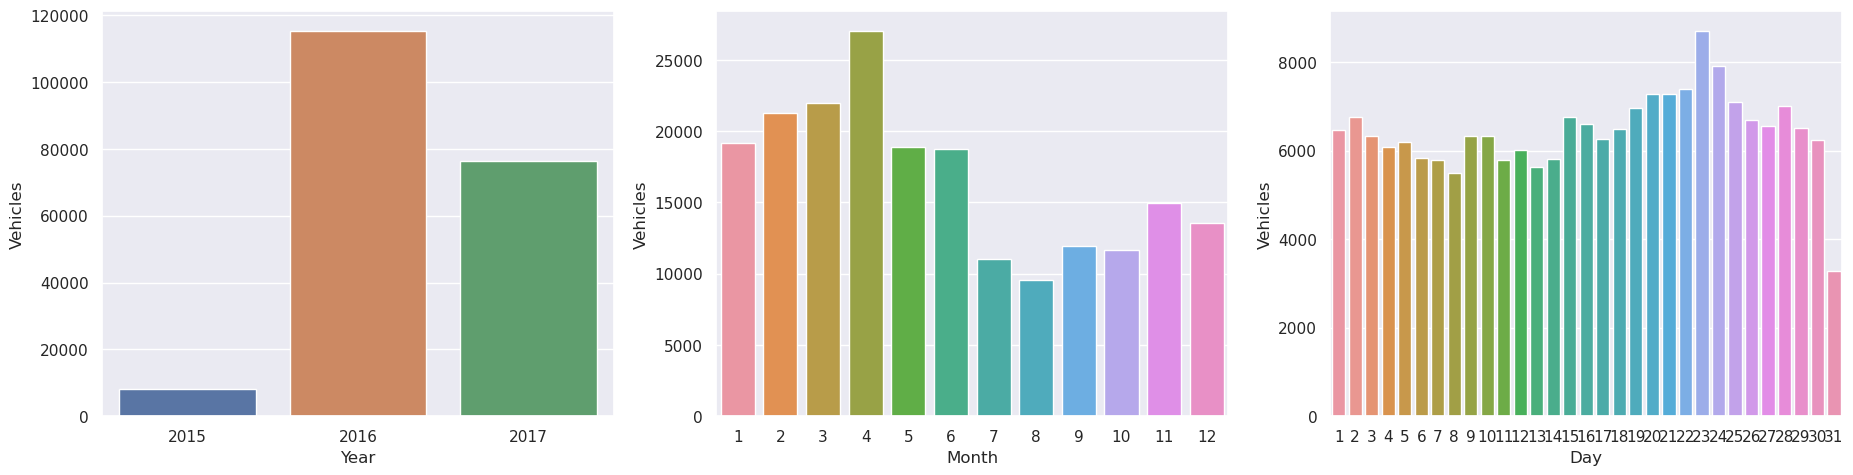

In [36]:
grouping_data_junc(data_junc_3)

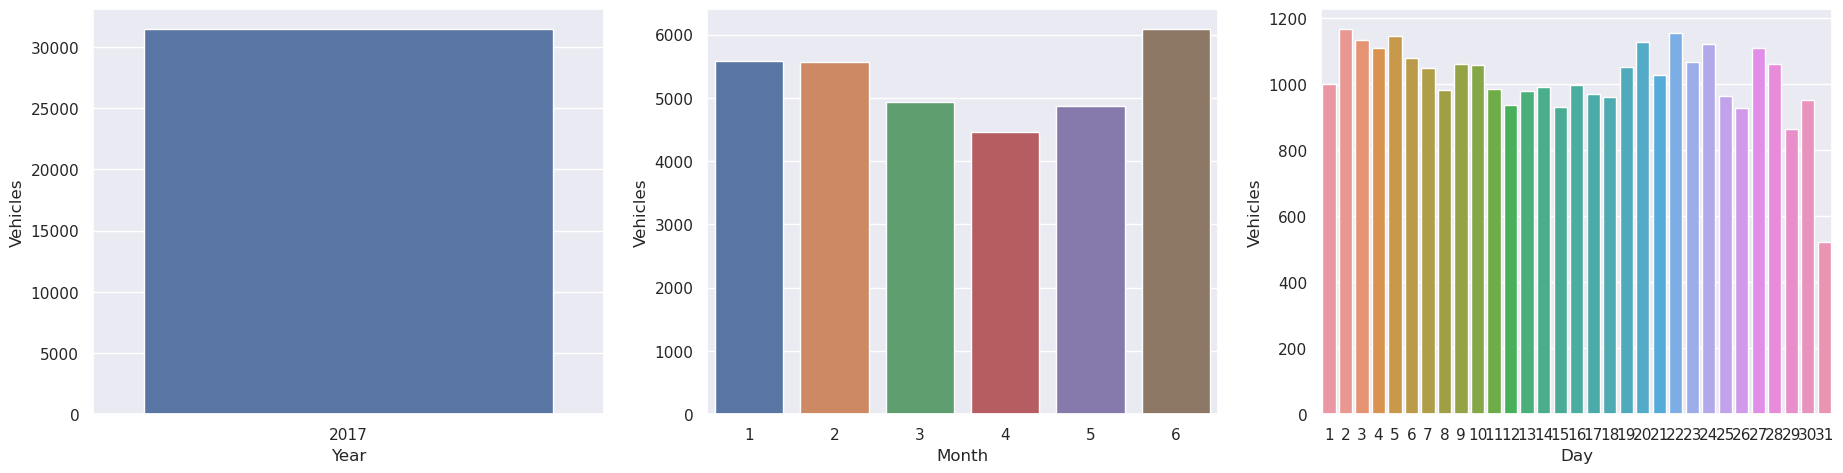

In [37]:
grouping_data_junc(data_junc_4)

from the above plot we can analyse which months and what day the particular junction  is more congested

In [38]:
year_grouping=data.groupby(['Year'])['Vehicles'].sum().reset_index()

In [39]:
year_grouping

Year  Vehicles
0  2015     50552
1  2016    563588
2  2017    482579

In [40]:
data[data['Year']==2015].groupby(['Month'])['Vehicles'].sum().reset_index()

Month  Vehicles
0     11     25729
1     12     24823

In [41]:
data[data['Year']==2016].groupby(['Month'])['Vehicles'].sum().reset_index()

Month  Vehicles
0       1     30801
1       2     36591
2       3     39089
3       4     41814
4       5     43641
5       6     40802
6       7     48742
7       8     48962
8       9     55393
9      10     59262
10     11     58659
11     12     59832

In [42]:
data[data['Year']==2017].groupby(['Month'])['Vehicles'].sum().reset_index()

Month  Vehicles
0      1     71939
1      2     73077
2      3     81077
3      4     81436
4      5     84650
5      6     90400

In [43]:
data[data['Year']==2015].groupby(['Day'])['Vehicles'].sum().reset_index()

Day  Vehicles
0     1      1494
1     2      1897
2     3      1787
3     4      1658
4     5      1369
5     6      1334
6     7      1395
7     8      1414
8     9      1643
9    10      1867
10   11      1676
11   12      1558
12   13      1484
13   14      1473
14   15      1492
15   16      1762
16   17      1907
17   18      2478
18   19      1957
19   20      1863
20   21      1727
21   22      1733
22   23      1877
23   24      1691
24   25      1378
25   26      1495
26   27      1435
27   28      1562
28   29      1592
29   30      1852
30   31       702

In [44]:
data[data['Year']==2016].groupby(['Day'])['Vehicles'].sum().reset_index()

Day  Vehicles
0     1     18422
1     2     18120
2     3     17640
3     4     17264
4     5     17357
5     6     17623
6     7     17827
7     8     18107
8     9     17888
9    10     17108
10   11     17516
11   12     18451
12   13     17524
13   14     18208
14   15     18963
15   16     18725
16   17     18110
17   18     18502
18   19     19328
19   20     19135
20   21     20088
21   22     19717
22   23     20046
23   24     19028
24   25     18452
25   26     19059
26   27     18492
27   28     19817
28   29     20133
29   30     17199
30   31      9739

In [45]:
data[data['Year']==2017].groupby(['Day'])['Vehicles'].sum().reset_index()

Day  Vehicles
0     1     14760
1     2     16200
2     3     15922
3     4     14815
4     5     15441
5     6     16222
6     7     15528
7     8     15659
8     9     16900
9    10     16398
10   11     14451
11   12     15090
12   13     16161
13   14     14787
14   15     15552
15   16     16184
16   17     15778
17   18     15030
18   19     16187
19   20     17336
20   21     16229
21   22     17031
22   23     17973
23   24     17015
24   25     15532
25   26     14993
26   27     16753
27   28     15913
28   29     13269
29   30     14676
30   31      8794

## Outlier detection

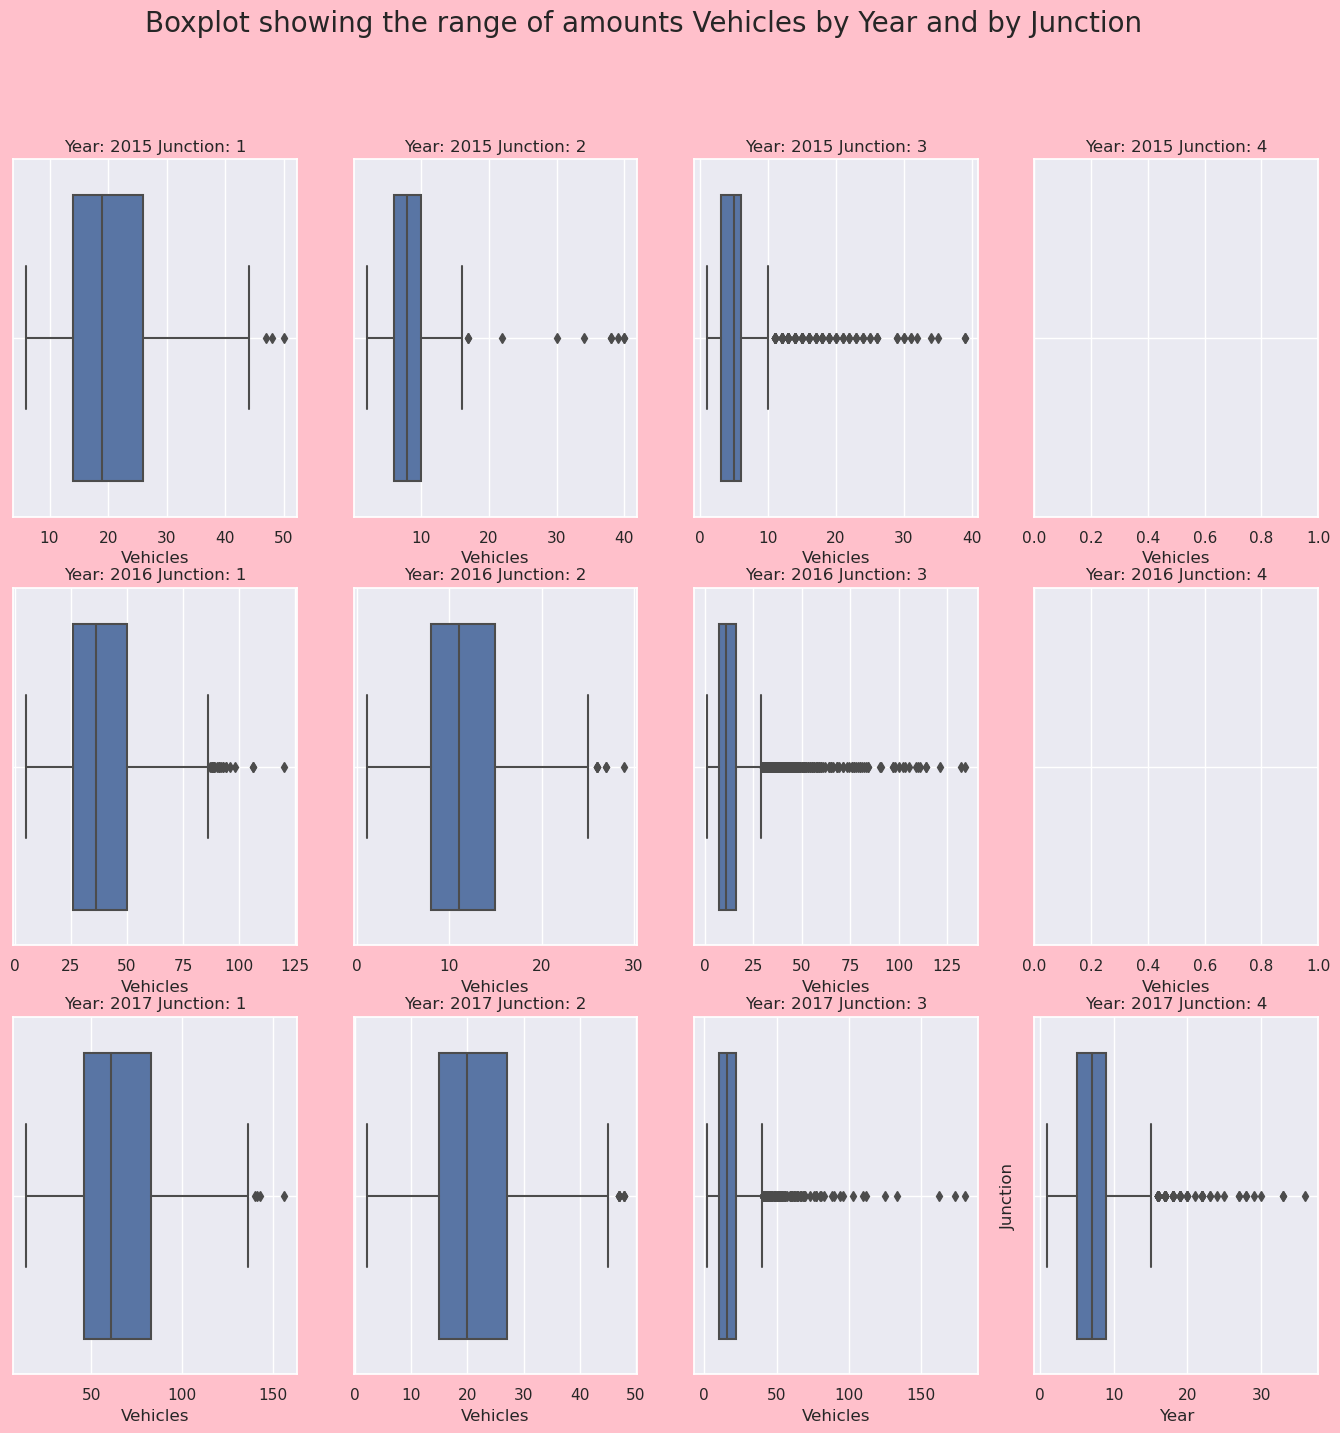

In [46]:
fig, axis = plt.subplots(3, 4, figsize=(15, 15))
fig.set_facecolor('pink')
years = range(2015, 2018)
junctions = range(1, 5)

for i, year in enumerate(years):
    for j, junction in enumerate(junctions):
        
        sns.boxplot(x=data[(data.Junction == junction) & (data.Year == year)]['Vehicles'], ax=axis[i, j])
        axis[i, j].grid(True, alpha=1, ls='solid')
        axis[i, j].set_title(f'Year: {year} Junction: {junction}')

plt.xlabel('Year')
plt.ylabel('Junction')
fig.suptitle('Boxplot showing the range of amounts Vehicles by Year and by Junction', fontsize=20)
plt.show()

lot of outliers in the data

In [47]:
corr = data.corr()
corr

Junction  Vehicles          Year         Month           Day  \
Junction  1.000000e+00 -0.613787  2.212977e-01 -1.242771e-01 -2.094621e-03   
Vehicles -6.137872e-01  1.000000  2.212531e-01 -2.272345e-02  2.789498e-02   
Year      2.212977e-01  0.221253  1.000000e+00 -6.234957e-01 -7.474779e-03   
Month    -1.242771e-01 -0.022723 -6.234957e-01  1.000000e+00  9.154760e-03   
Day      -2.094621e-03  0.027895 -7.474779e-03  9.154760e-03  1.000000e+00   
hour     -2.132575e-15  0.219938  7.732006e-16  4.953278e-16 -9.917806e-18   

                  hour  
Junction -2.132575e-15  
Vehicles  2.199377e-01  
Year      7.732006e-16  
Month     4.953278e-16  
Day      -9.917806e-18  
hour      1.000000e+00

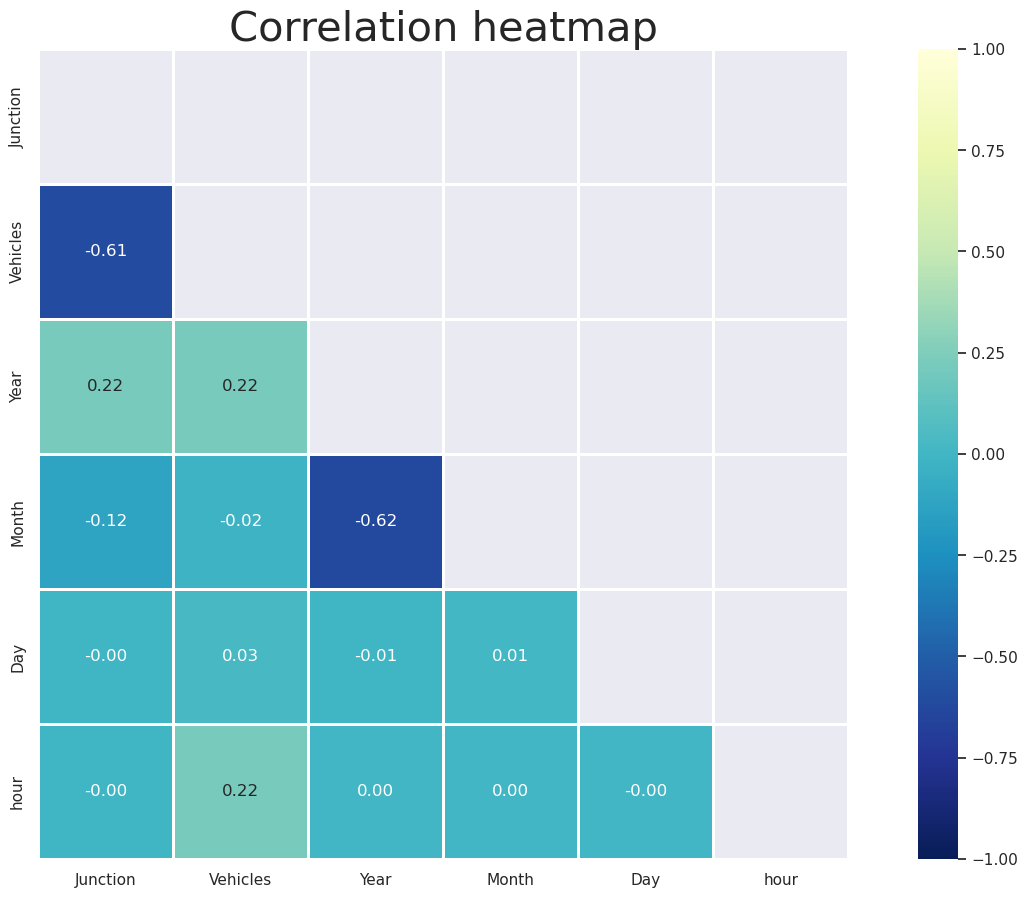

In [48]:
# Create a mask to filter the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Create the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(corr, annot=True, fmt='.2f', vmin=-1, vmax=1, square=True, linewidths=1, cmap="YlGnBu_r", mask=mask)
plt.title('Correlation heatmap', fontsize=30)
plt.show()

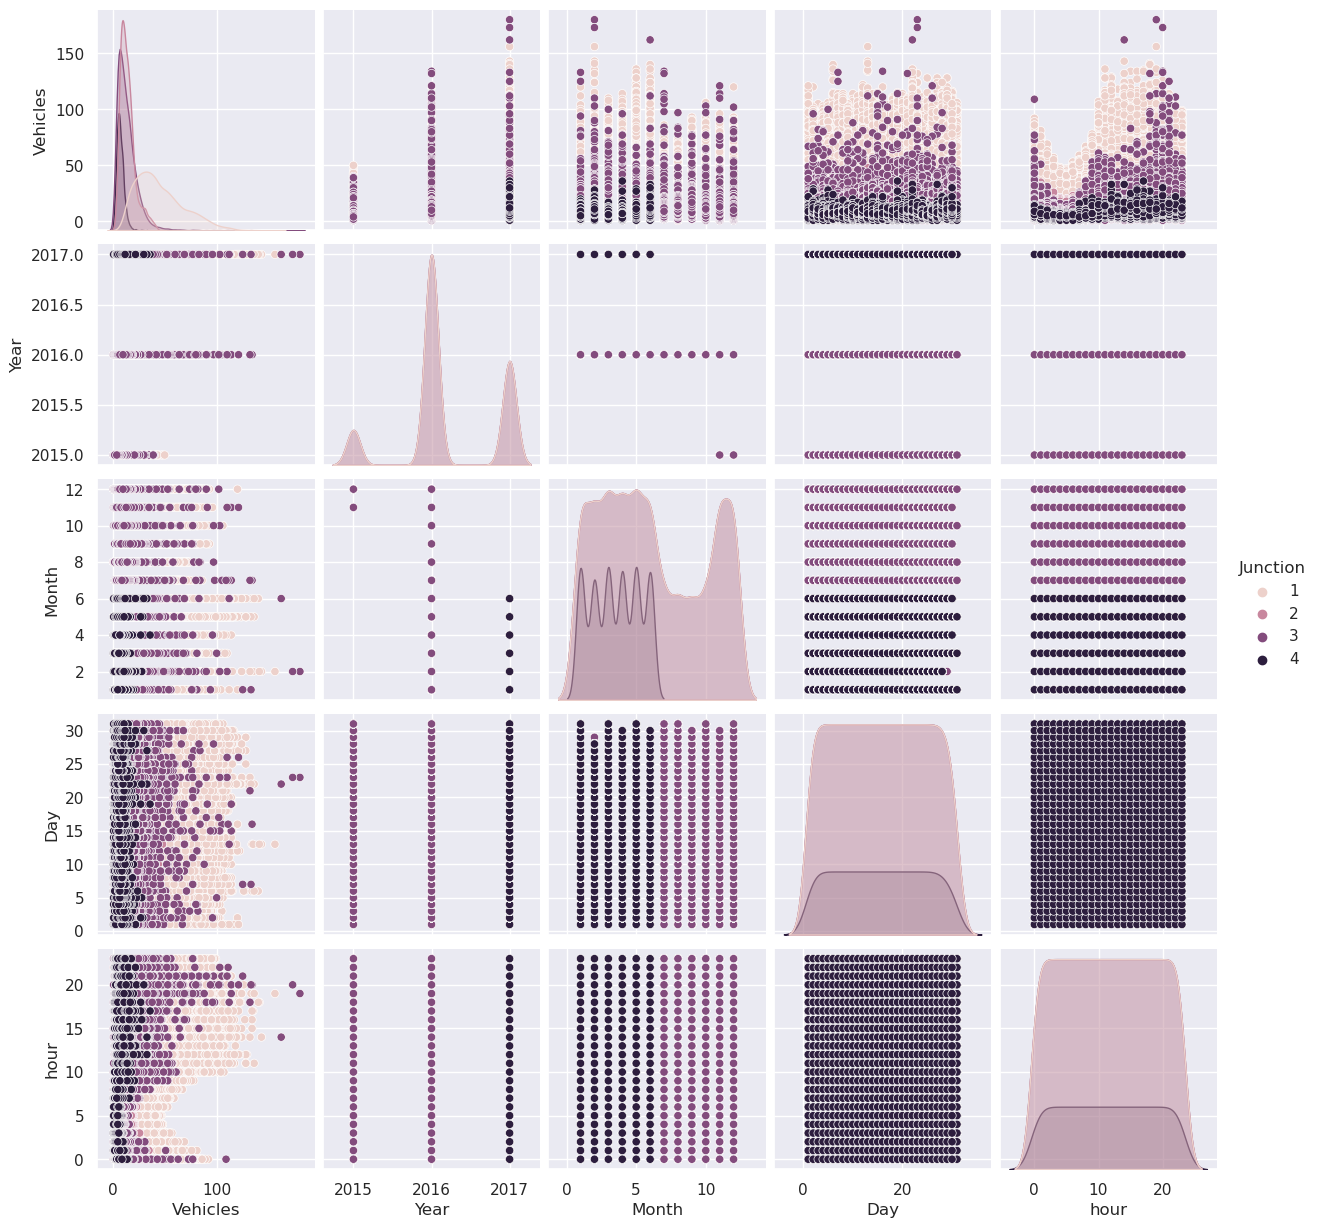

In [49]:
sns.pairplot(data=data, hue= "Junction")

In [50]:
data2=data.set_index('DateTime')

In [51]:
data2

Junction  Vehicles  Year  Month  Day  hour
DateTime                                                       
2015-11-01 00:00:00         1        15  2015     11    1     0
2015-11-01 01:00:00         1        13  2015     11    1     1
2015-11-01 02:00:00         1        10  2015     11    1     2
2015-11-01 03:00:00         1         7  2015     11    1     3
2015-11-01 04:00:00         1         9  2015     11    1     4
...                       ...       ...   ...    ...  ...   ...
2017-06-30 19:00:00         4        11  2017      6   30    19
2017-06-30 20:00:00         4        30  2017      6   30    20
2017-06-30 21:00:00         4        16  2017      6   30    21
2017-06-30 22:00:00         4        22  2017      6   30    22
2017-06-30 23:00:00         4        12  2017      6   30    23

[48120 rows x 6 columns]

In [52]:
def get_list_data(dataf, drop=[]):
    # Drop specified columns from dataframe
    dataf = dataf.drop(drop, axis=1, errors='ignore')
    # Create a list of dataframes with data from each junction
    data_list = [dataf[dataf.Junction == i].drop('Junction', axis=1) for i in range(5)]
    return data_list

In [53]:
data1 = get_list_data(data2)
for i in data1:
    print(i.head(1))

Empty DataFrame
Columns: [Vehicles, Year, Month, Day, hour]
Index: []
            Vehicles  Year  Month  Day  hour
DateTime                                    
2015-11-01        15  2015     11    1     0
            Vehicles  Year  Month  Day  hour
DateTime                                    
2015-11-01         6  2015     11    1     0
            Vehicles  Year  Month  Day  hour
DateTime                                    
2015-11-01         9  2015     11    1     0
            Vehicles  Year  Month  Day  hour
DateTime                                    
2017-01-01         3  2017      1    1     0


In [54]:
data1,len(data1)

([Empty DataFrame
  Columns: [Vehicles, Year, Month, Day, hour]
  Index: [],
                       Vehicles  Year  Month  Day  hour
  DateTime                                             
  2015-11-01 00:00:00        15  2015     11    1     0
  2015-11-01 01:00:00        13  2015     11    1     1
  2015-11-01 02:00:00        10  2015     11    1     2
  2015-11-01 03:00:00         7  2015     11    1     3
  2015-11-01 04:00:00         9  2015     11    1     4
  ...                       ...   ...    ...  ...   ...
  2017-06-30 19:00:00       105  2017      6   30    19
  2017-06-30 20:00:00        96  2017      6   30    20
  2017-06-30 21:00:00        90  2017      6   30    21
  2017-06-30 22:00:00        84  2017      6   30    22
  2017-06-30 23:00:00        78  2017      6   30    23
  
  [14592 rows x 5 columns],
                       Vehicles  Year  Month  Day  hour
  DateTime                                             
  2015-11-01 00:00:00         6  2015     11    1   

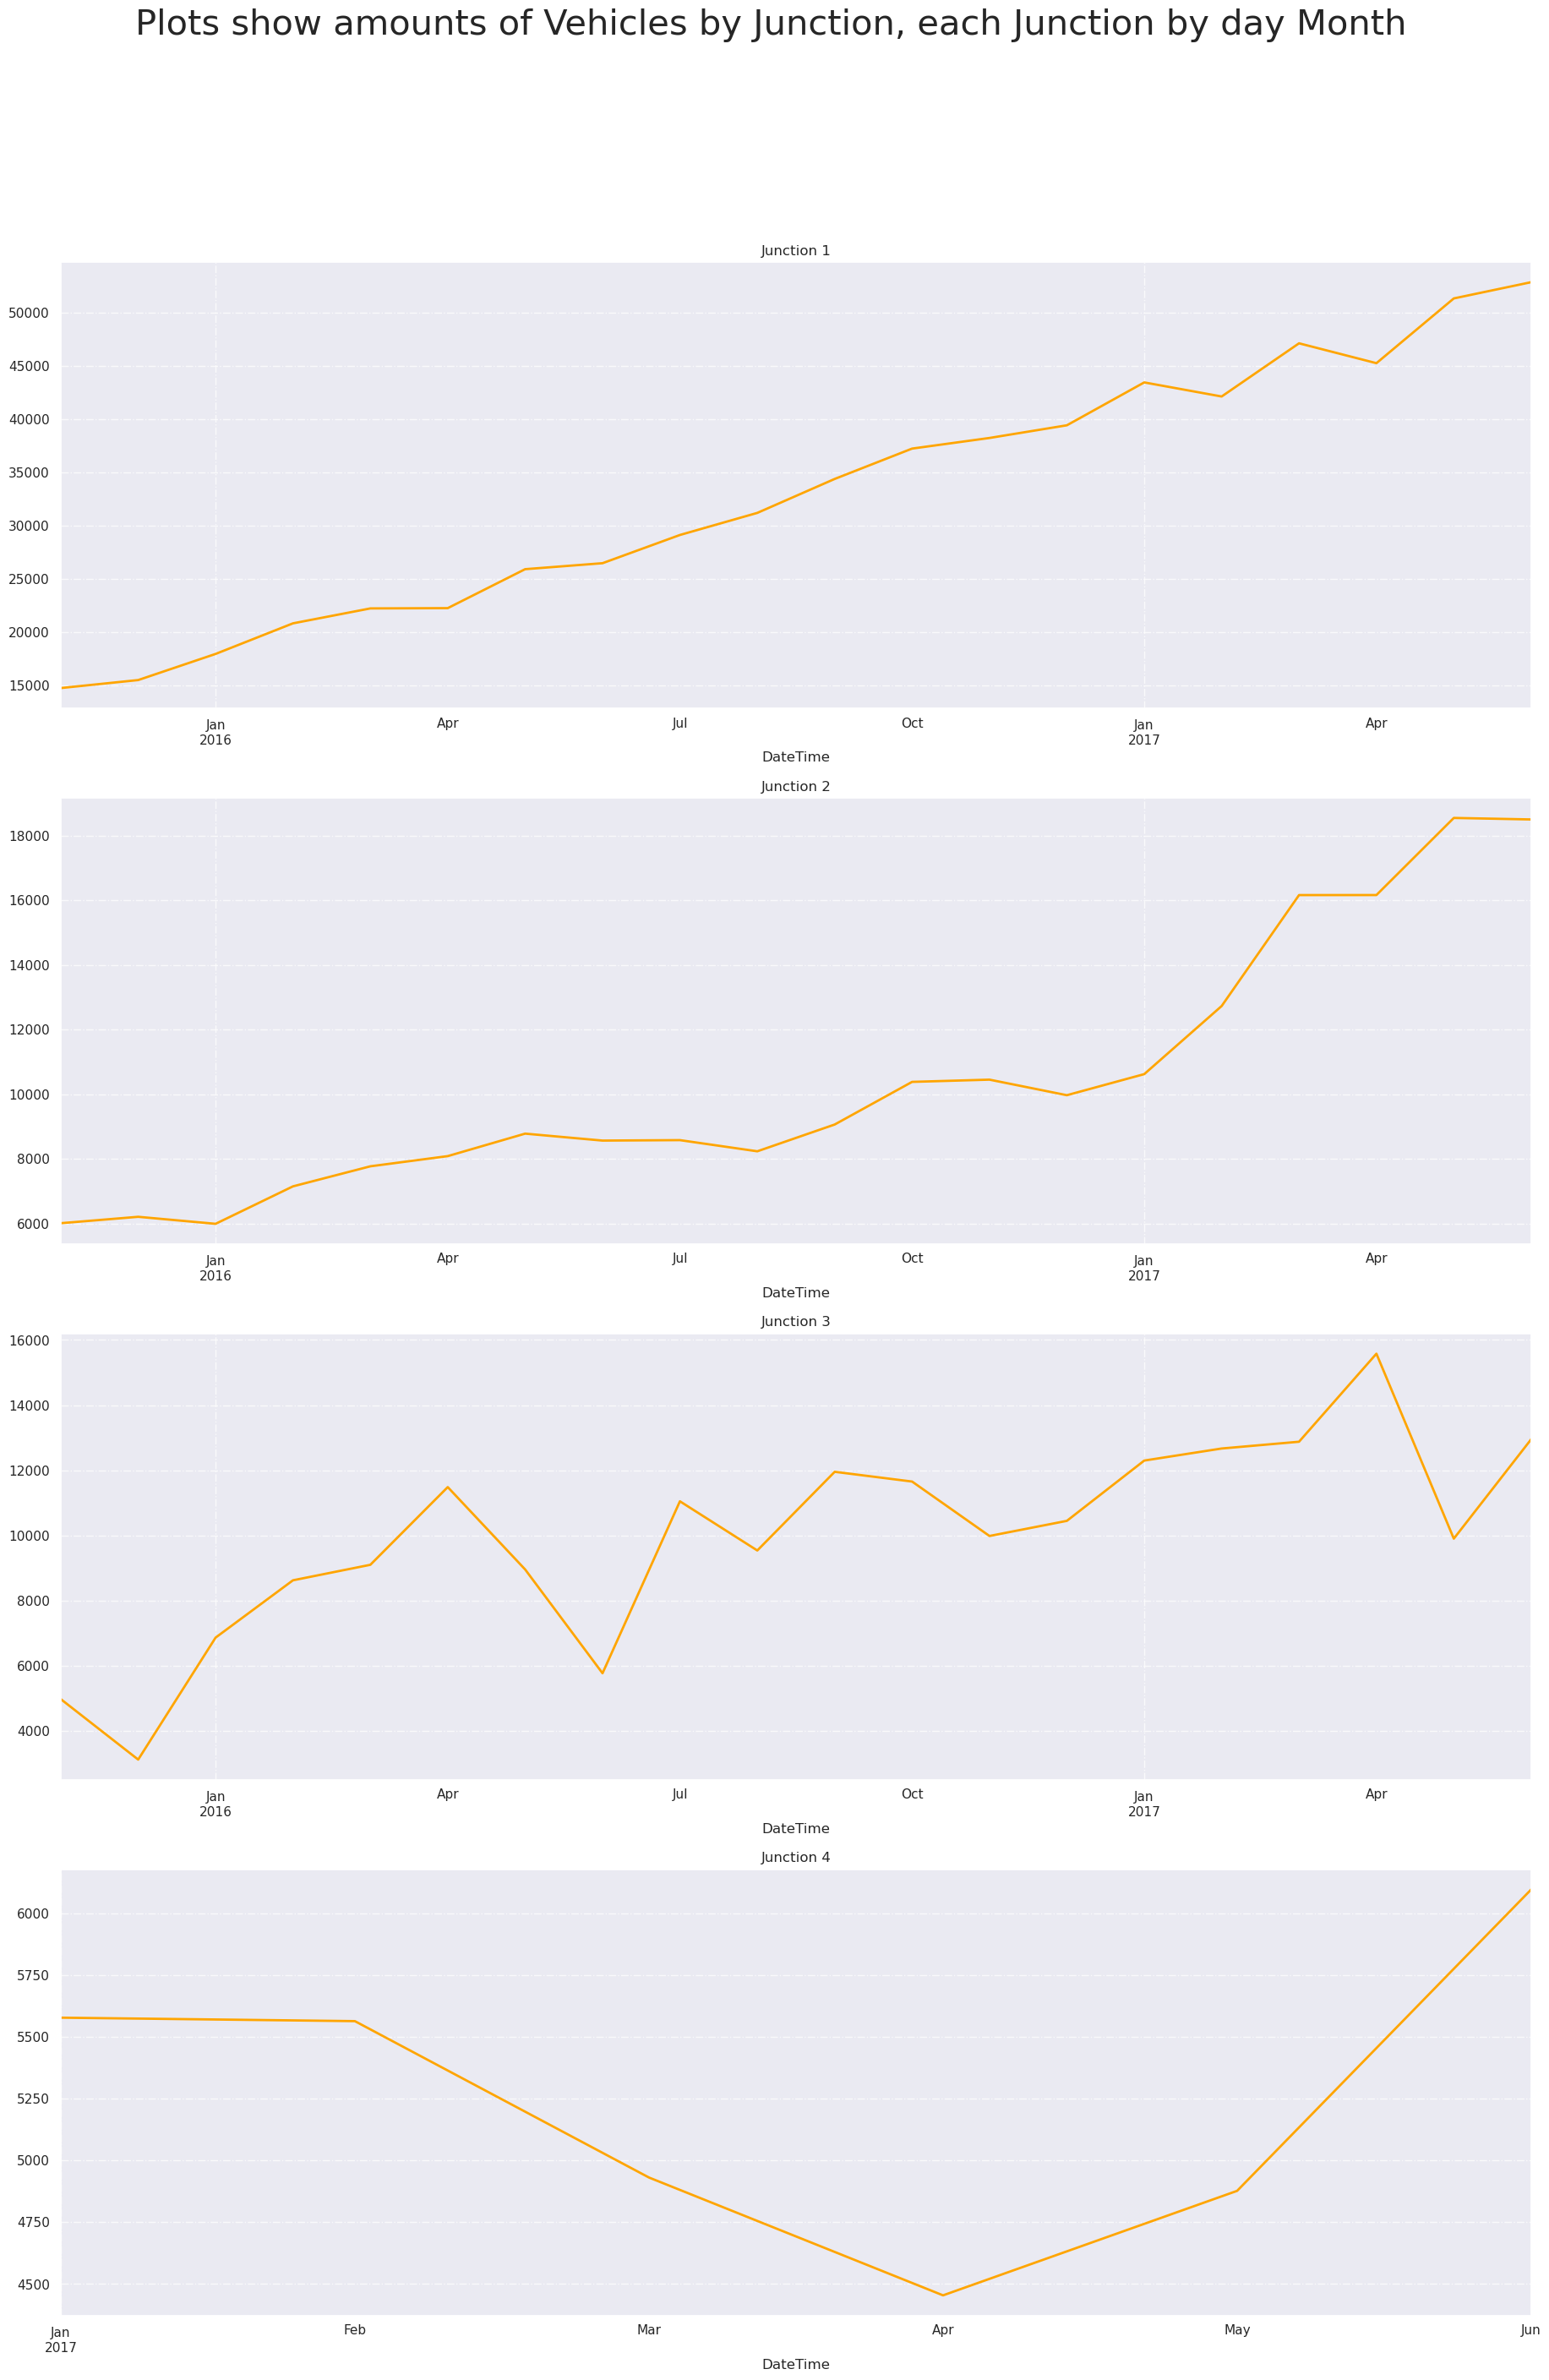

In [55]:
data1 = get_list_data(data2)
fig, ax = plt.subplots(nrows=4, figsize=(20, 30))
[data1[i + 1].resample('M').sum().Vehicles.plot(label=f'Vehicles of {i + 1} Junction', lw=2,ax=ax[i], color='orange') for i in range(4)]
[ax[i].grid(True, alpha=0.75, lw=1, ls='-.') for i in range(4)]
[ax[i].set_title(f'Junction {i + 1}') for i in range(4)]
plt.suptitle('Plots show amounts of Vehicles by Junction, each Junction by day Month', fontsize=30)
plt.show()

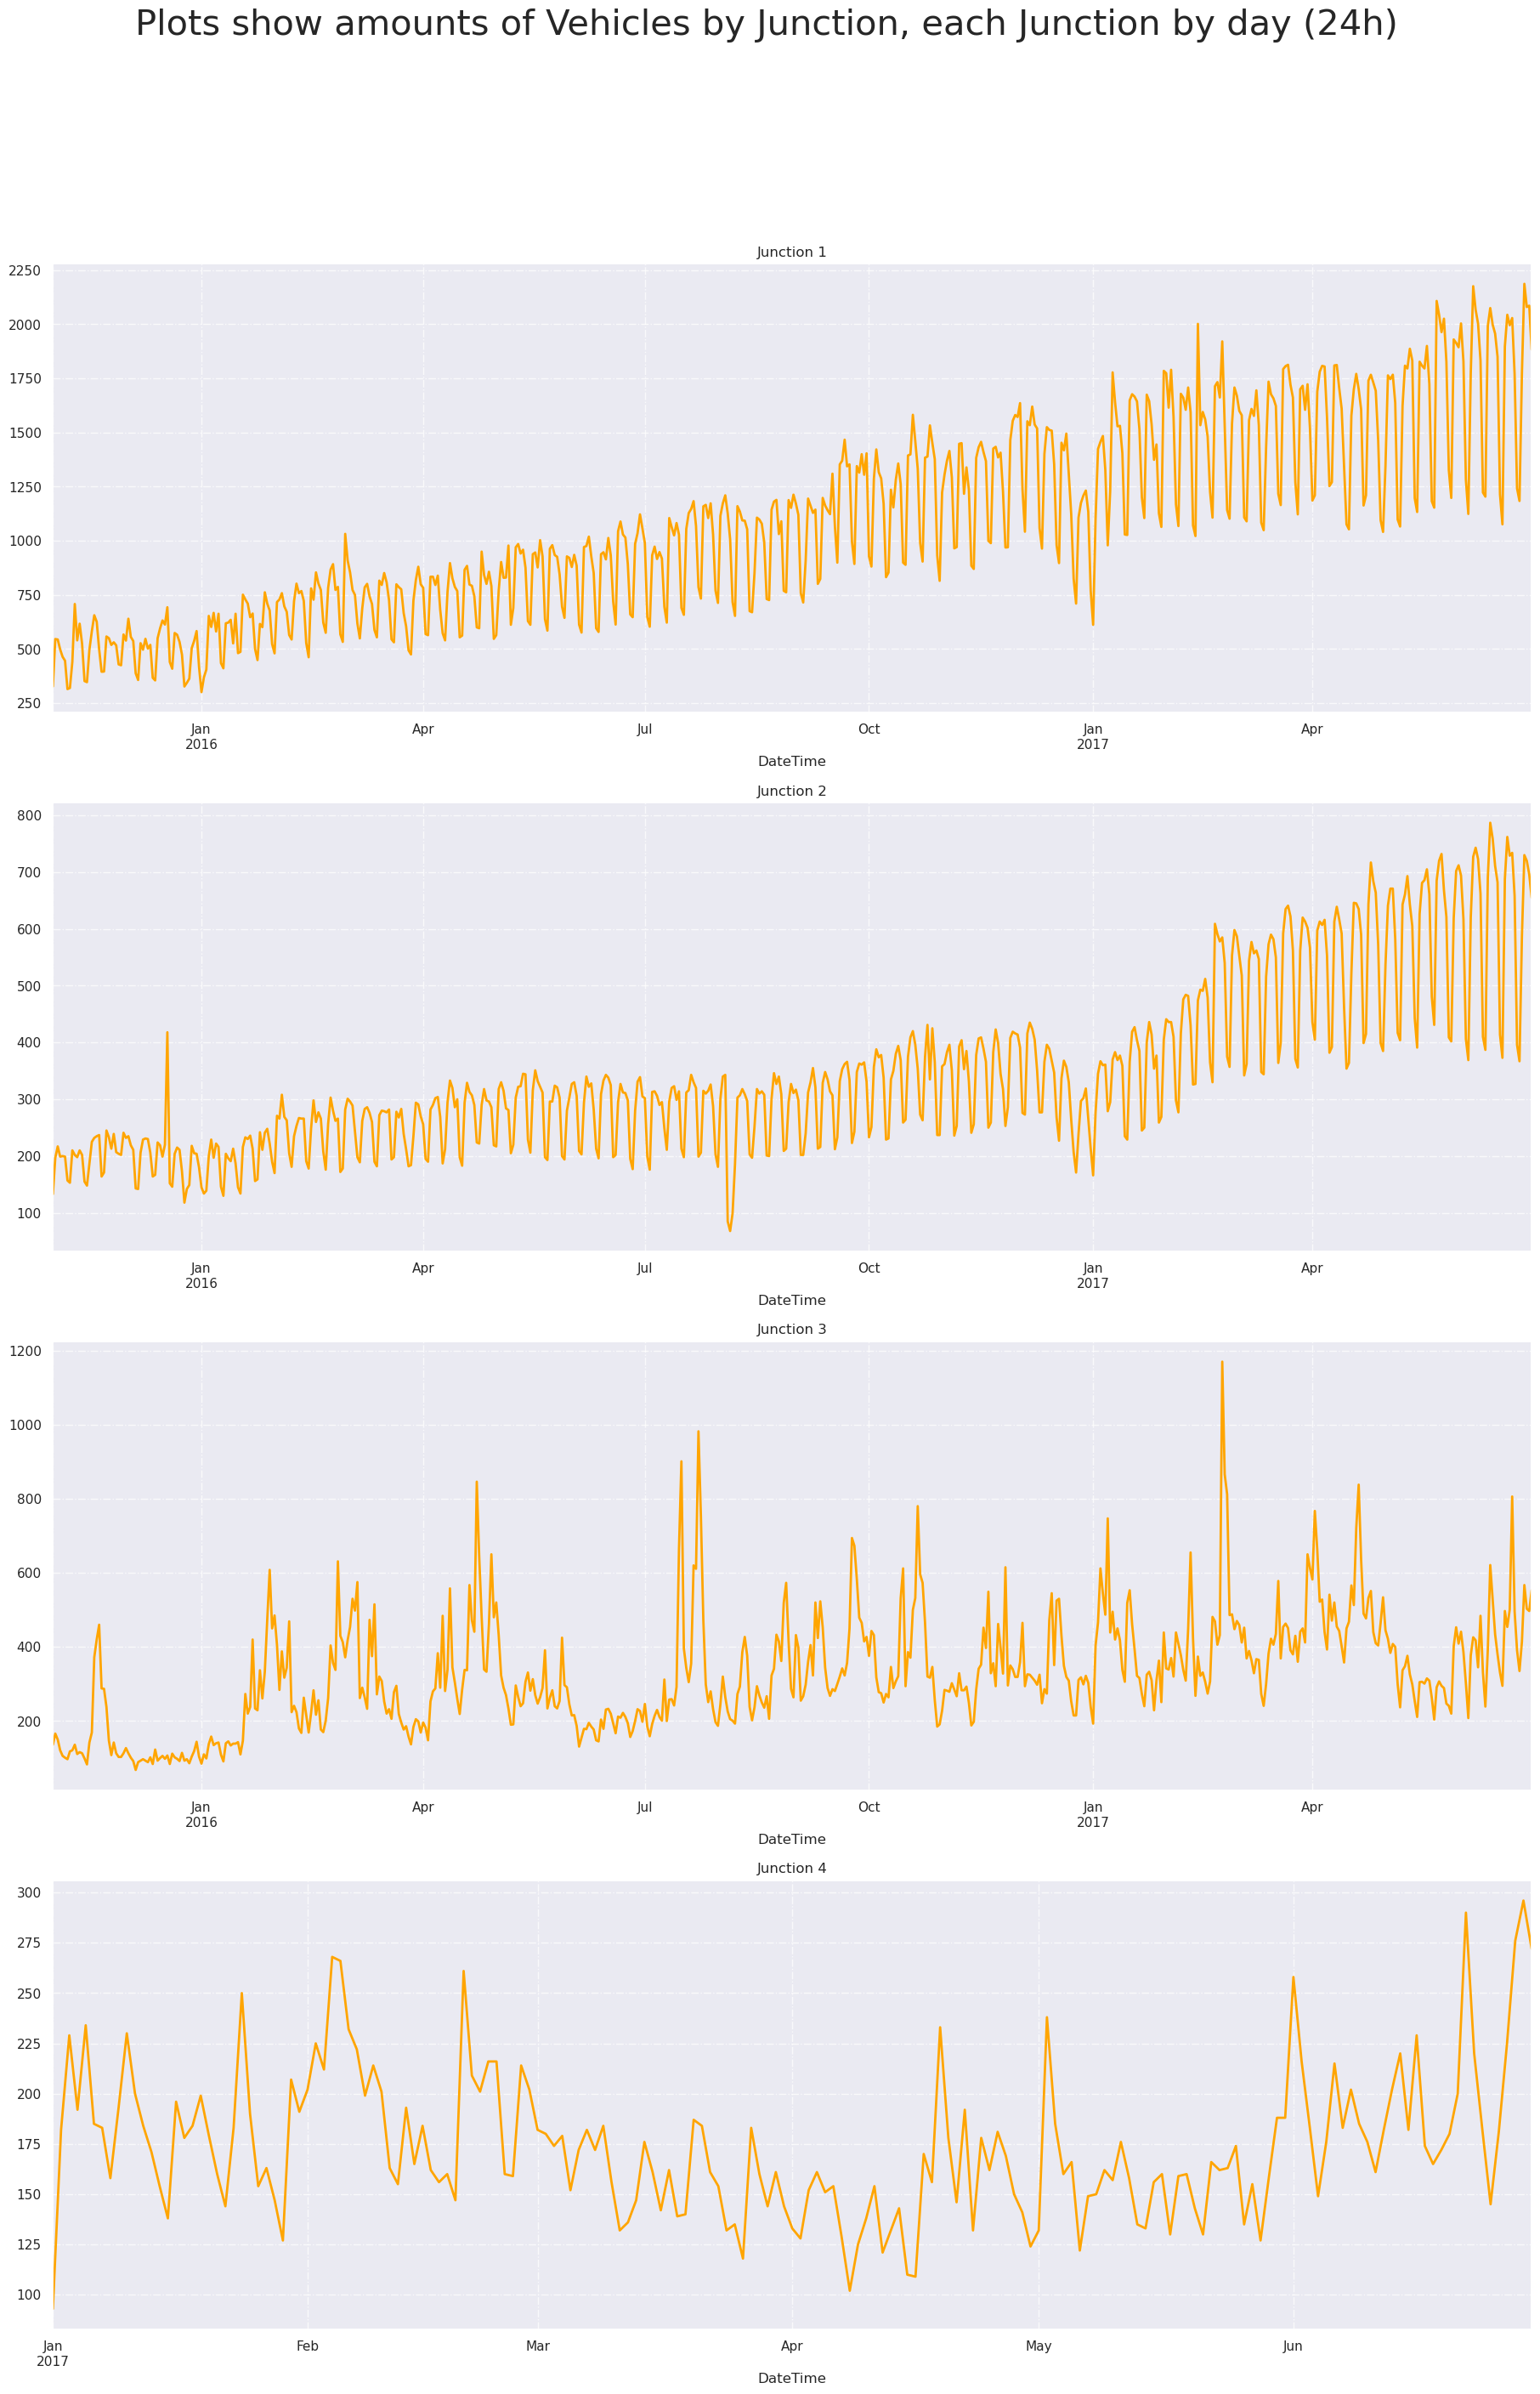

In [56]:
data1 = get_list_data(data2)
fig, ax = plt.subplots(nrows=4, figsize=(20, 30))
[data1[i + 1].resample('D').sum().Vehicles.plot(label=f'Vehicles of {i + 1} Junction', lw=2,ax=ax[i], color='orange') for i in range(4)]
[ax[i].grid(True, alpha=0.75, lw=1, ls='-.') for i in range(4)]
[ax[i].set_title(f'Junction {i + 1}') for i in range(4)]
plt.suptitle('Plots show amounts of Vehicles by Junction, each Junction by day (24h)', fontsize=30)
plt.show()

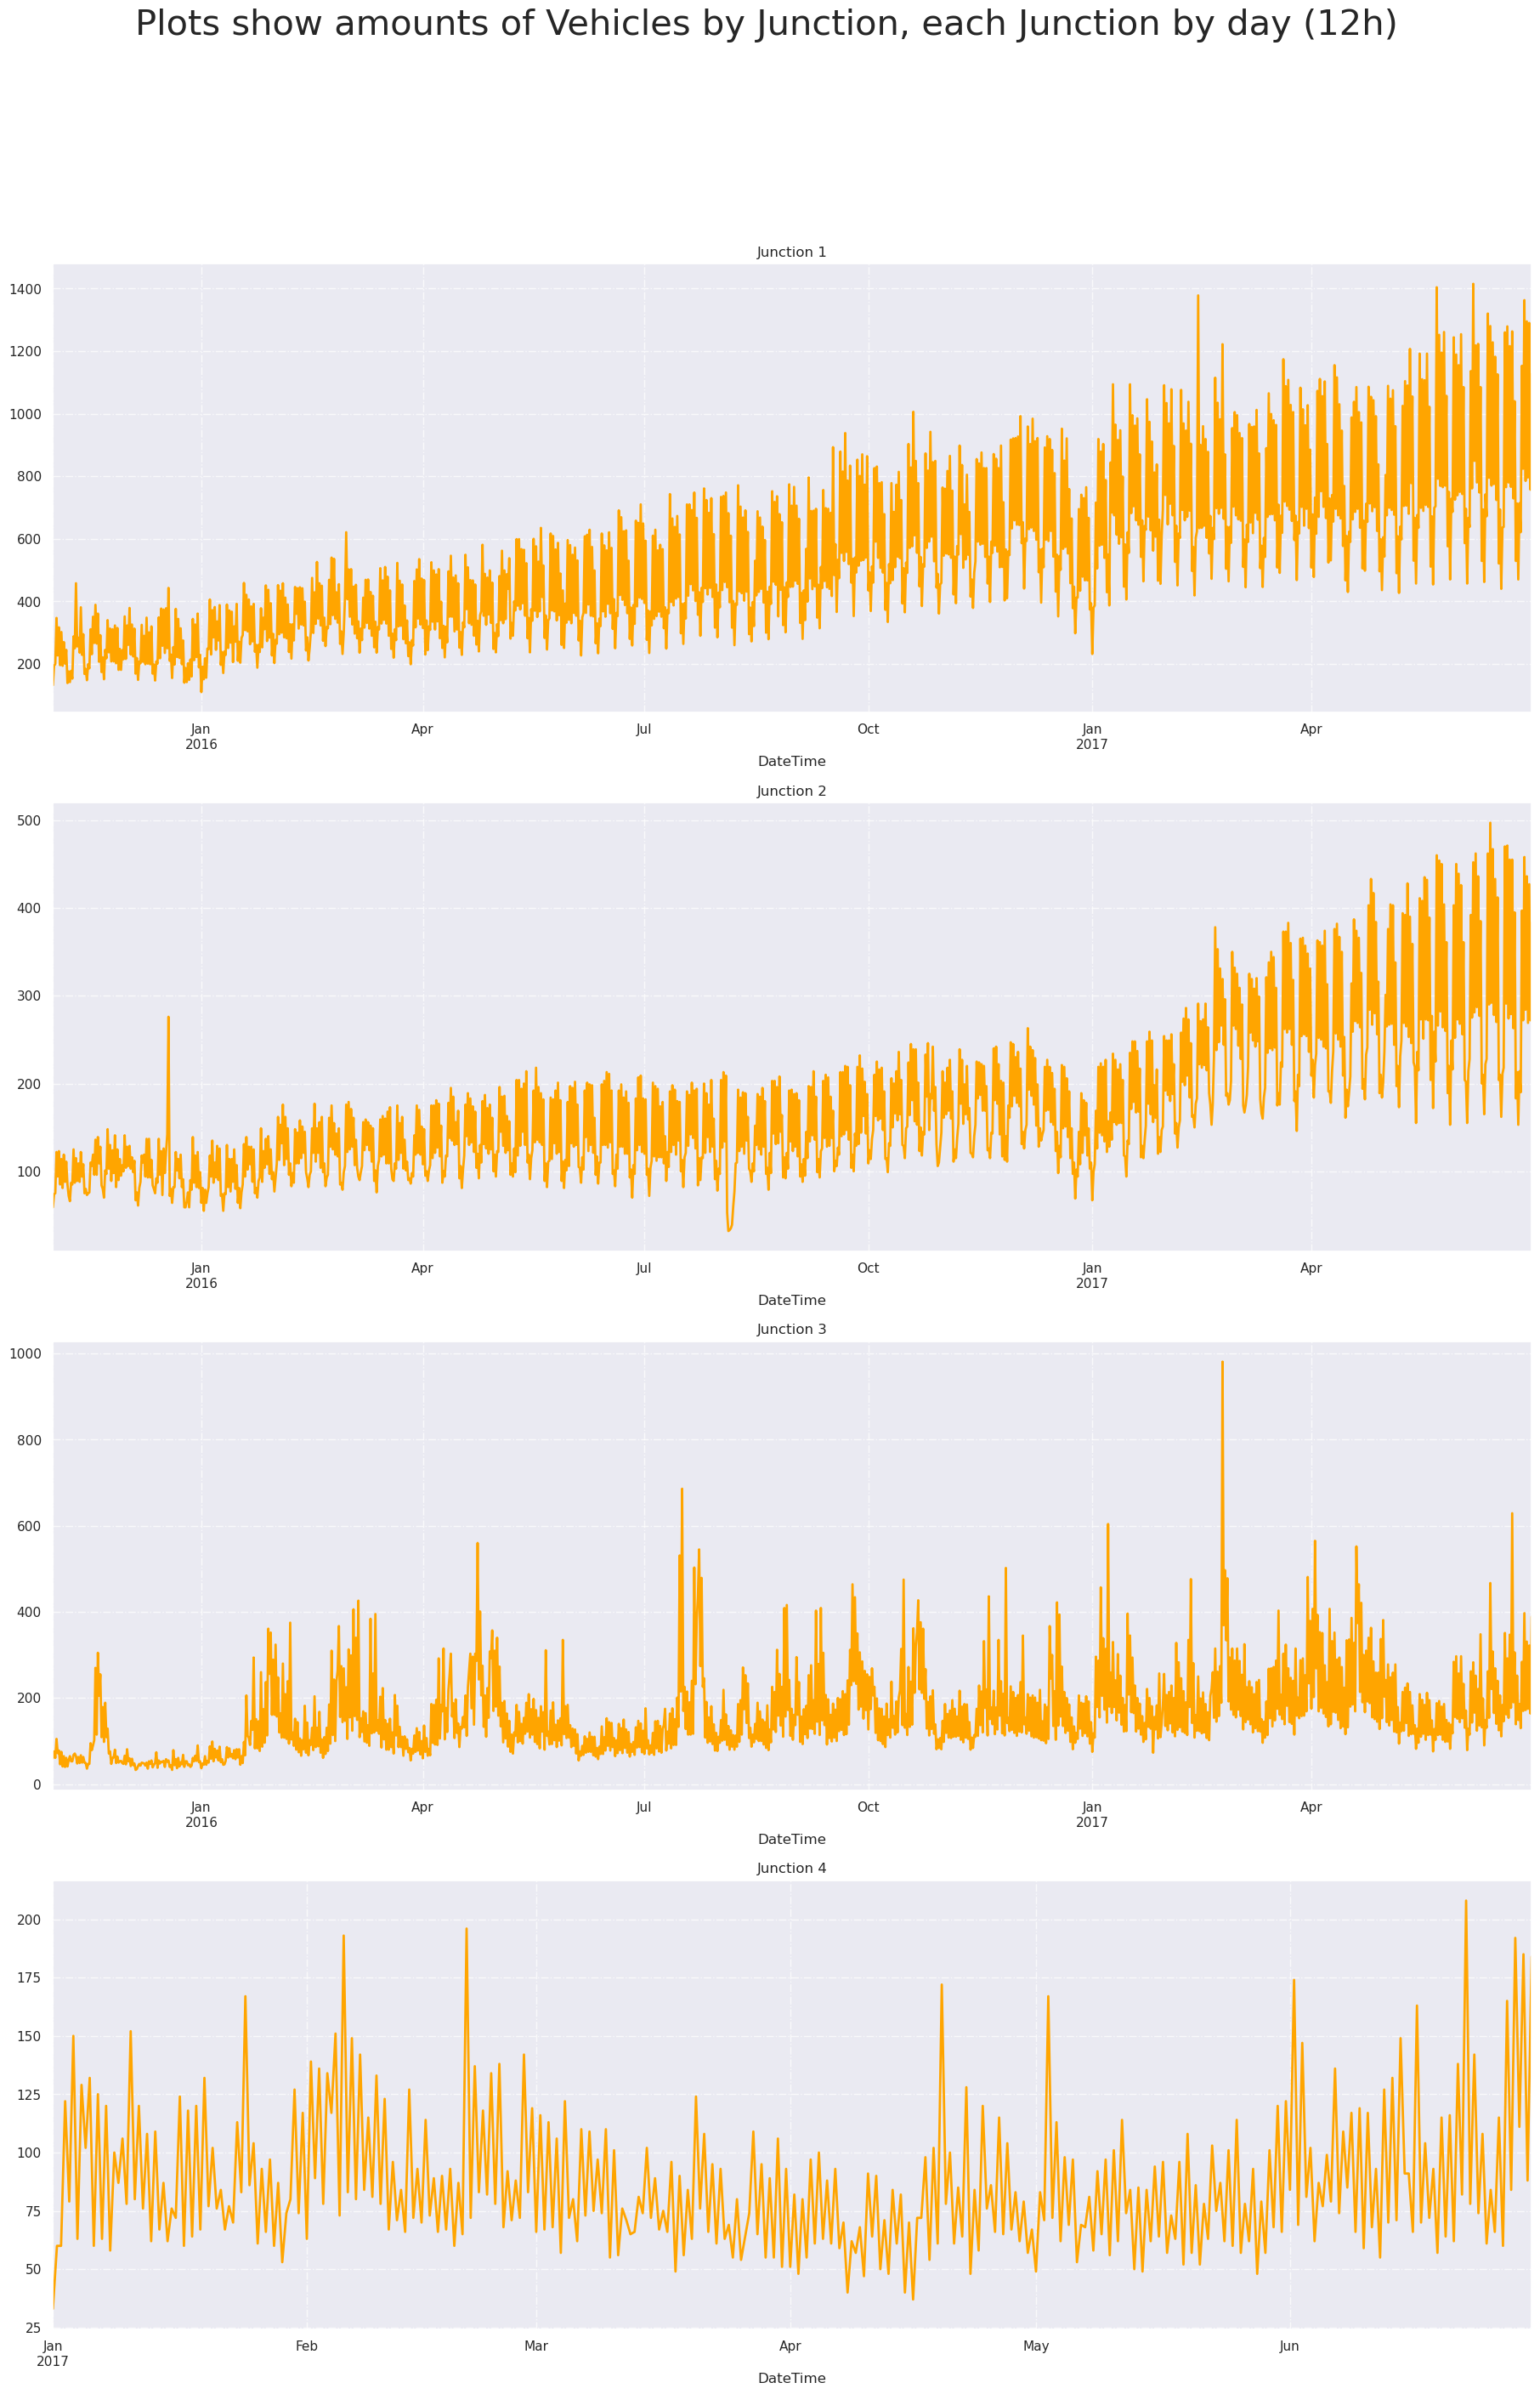

In [57]:
data1 = get_list_data(data2)
fig, ax = plt.subplots(nrows=4, figsize=(20, 30))
[data1[i + 1].resample('12H').sum().Vehicles.plot(label=f'Vehicles of {i + 1} Junction', lw=2,ax=ax[i], color='orange') for i in range(4)]
[ax[i].grid(True, alpha=0.75, lw=1, ls='-.') for i in range(4)]
[ax[i].set_title(f'Junction {i + 1}') for i in range(4)]
plt.suptitle('Plots show amounts of Vehicles by Junction, each Junction by day (12h)', fontsize=30)
plt.show()

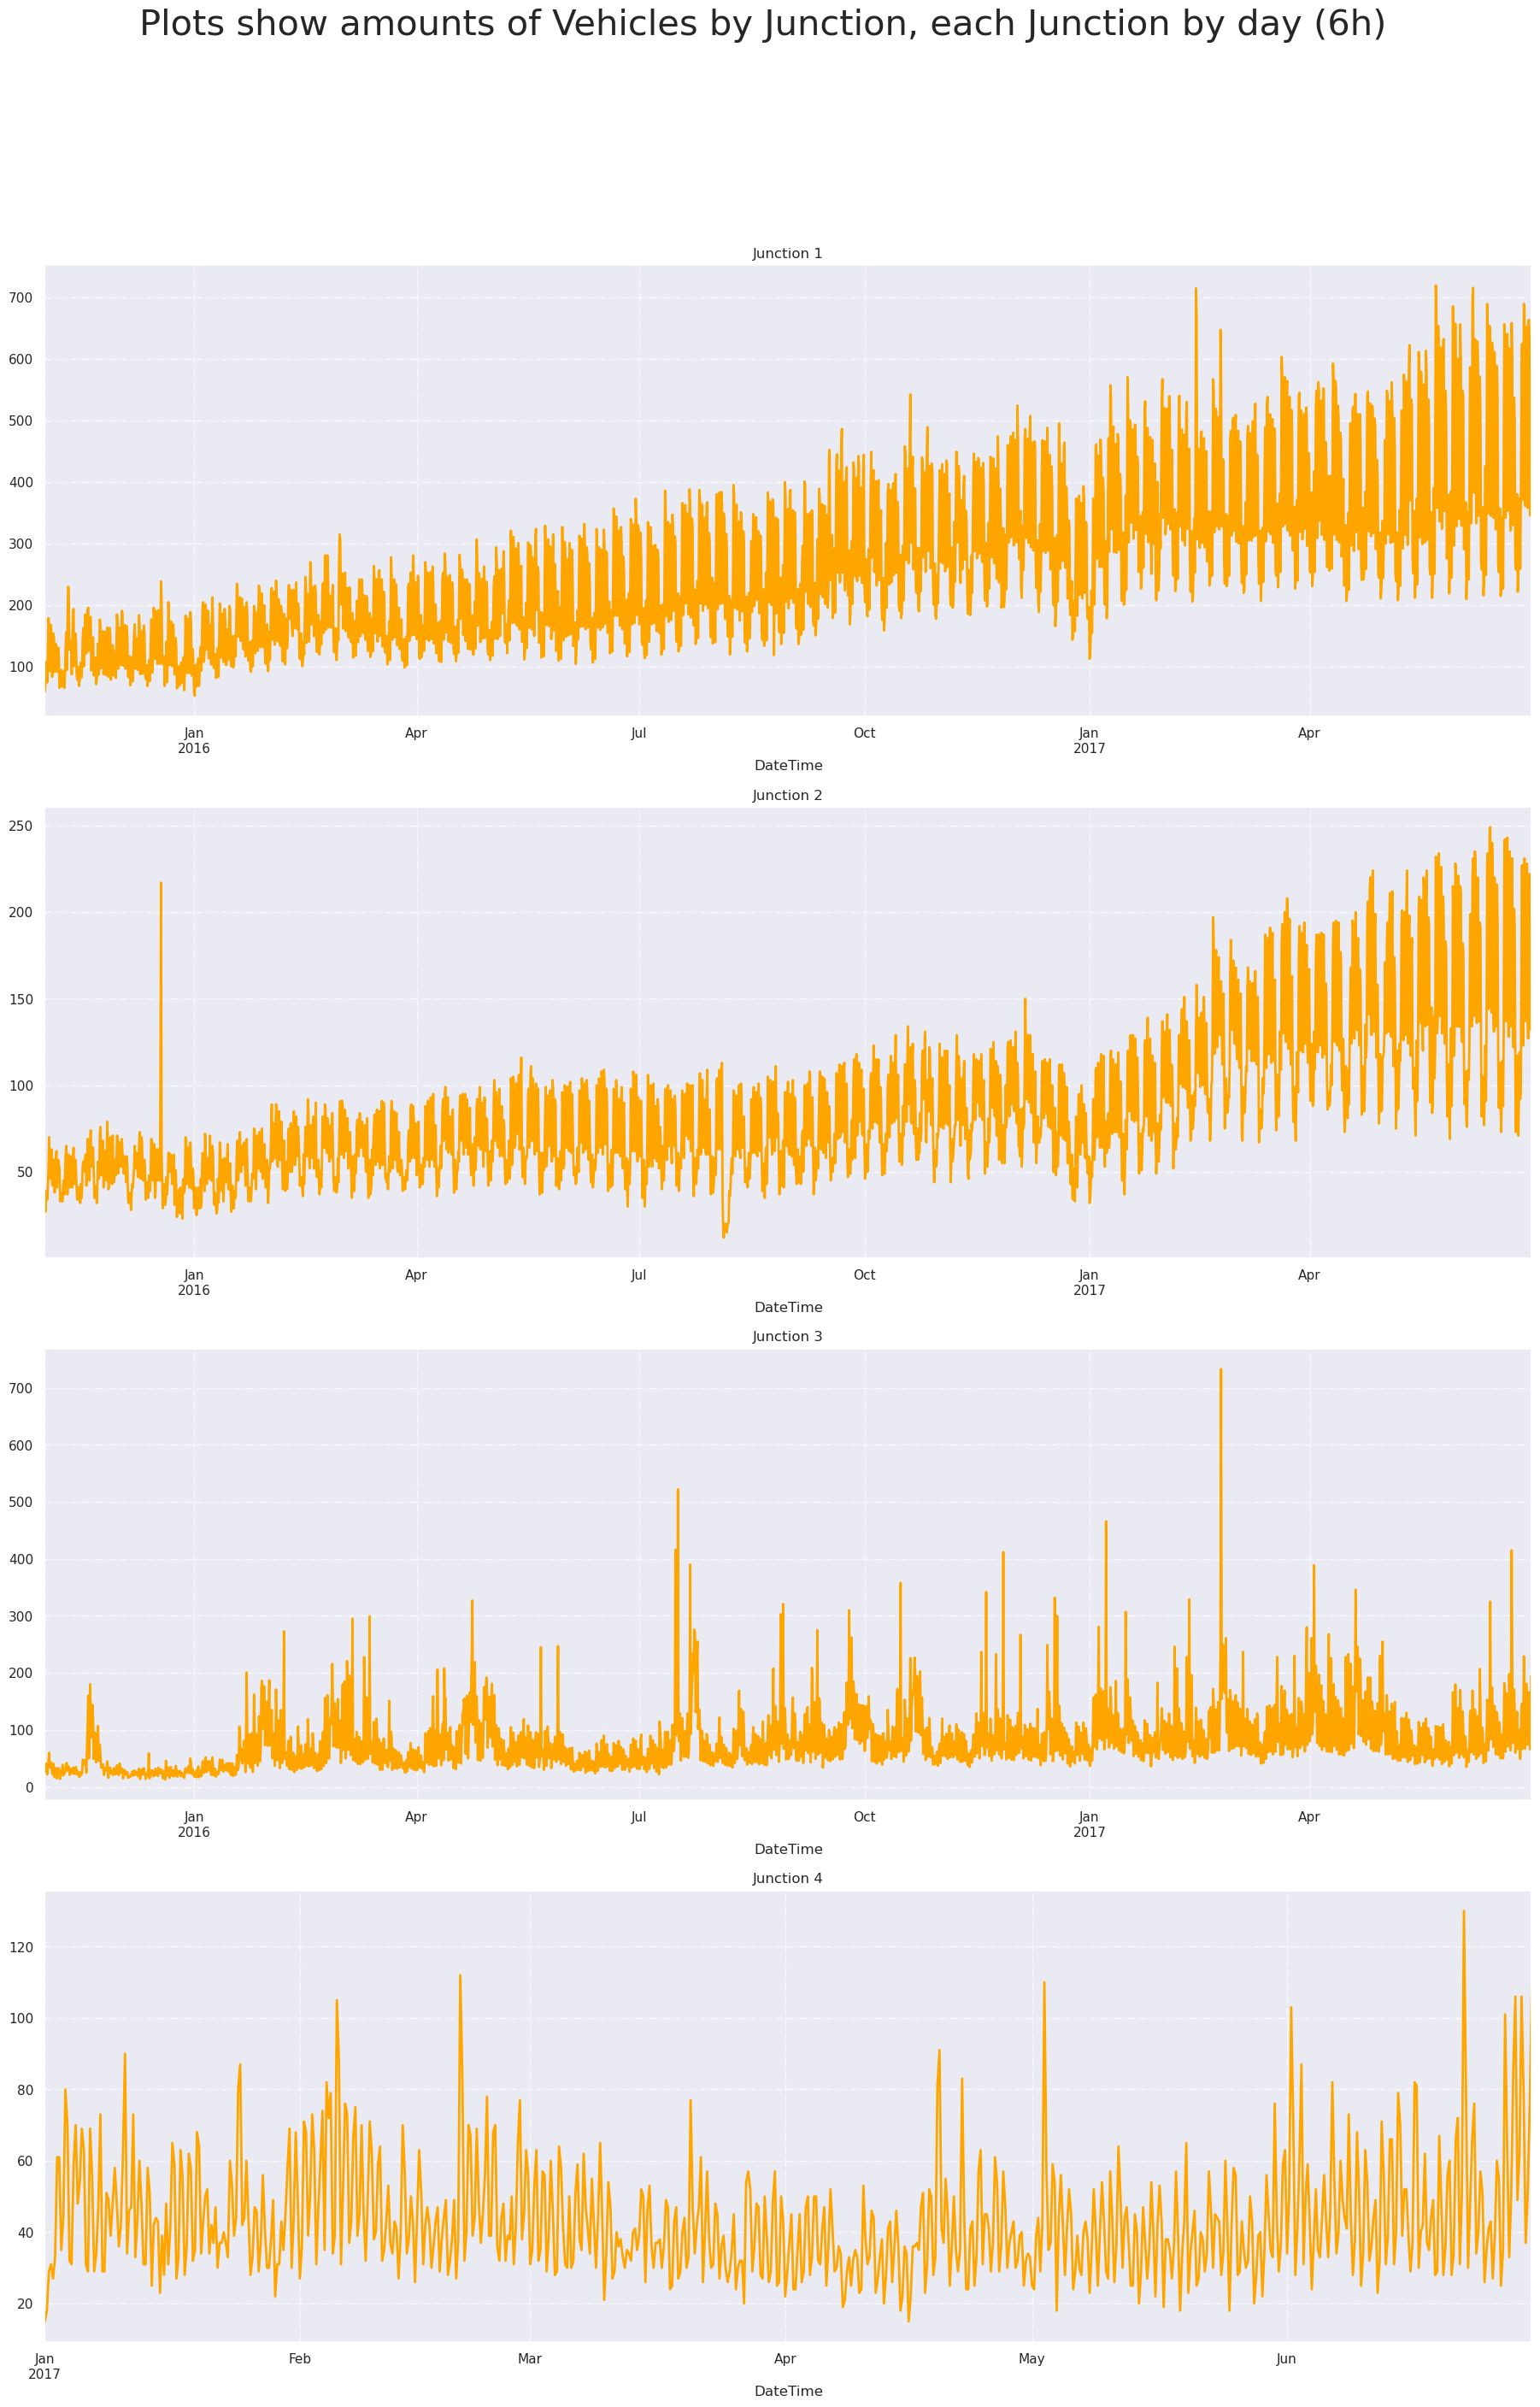

In [58]:
data1 = get_list_data(data2)
fig, ax = plt.subplots(nrows=4, figsize=(20, 30))
[data1[i + 1].resample('6H').sum().Vehicles.plot(label=f'Vehicles of {i + 1} Junction', lw=2,ax=ax[i], color='orange') for i in range(4)]
[ax[i].grid(True, alpha=0.75, lw=1, ls='-.') for i in range(4)]
[ax[i].set_title(f'Junction {i + 1}') for i in range(4)]
plt.suptitle('Plots show amounts of Vehicles by Junction, each Junction by day (6h)', fontsize=30)
plt.show()

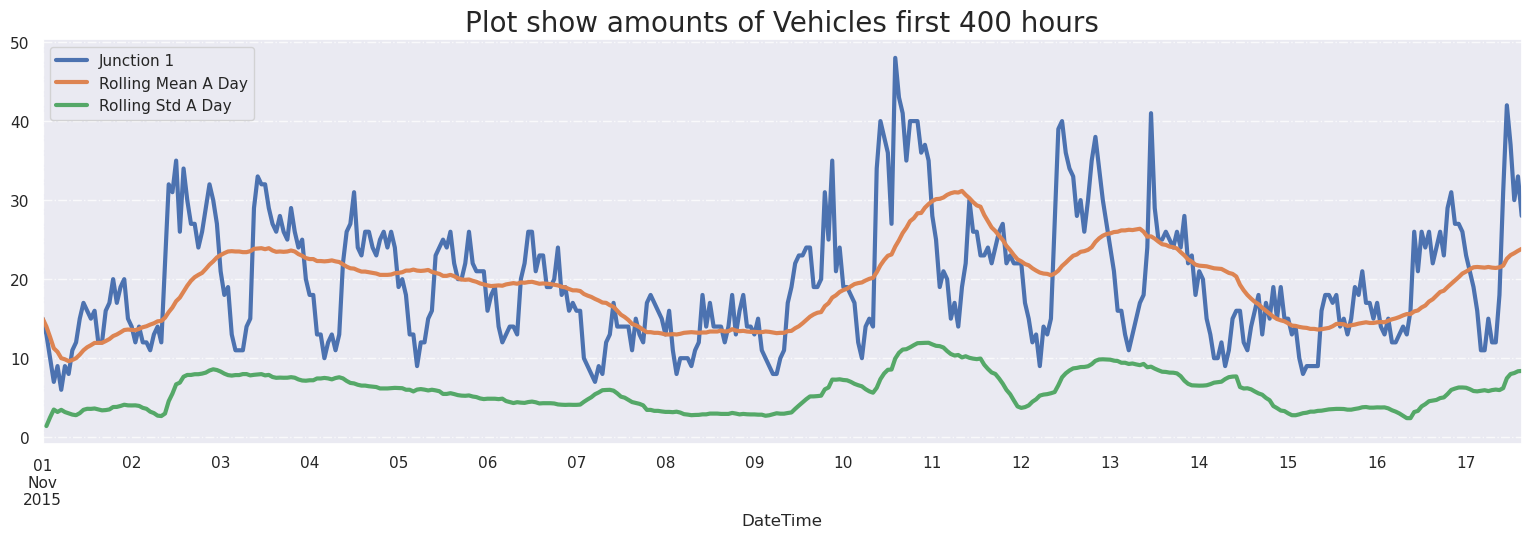

In [59]:
fig, ax = plt.subplots(figsize=(17, 5))
hrs400_data = data1[1][:400]
hrs400_data.Vehicles.plot(ax=ax, lw=3, label='Junction 1')
hrs400_data.Vehicles.rolling('D').mean().plot(ax=ax, lw=3, label='Rolling Mean A Day')
hrs400_data.Vehicles.rolling('D').std().plot(ax=ax, lw=3, label='Rolling Std A Day')
plt.legend()
plt.grid(True, alpha=0.75, ls='-.')
plt.title('Plot show amounts of Vehicles first 400 hours', fontsize=20)
plt.show()


In [60]:
def make_autocorrelation1(junction=1):
    fig, ax = plt.subplots(figsize=(17, 6), nrows=2)
    plot_acf(data1[junction].Vehicles, lags=40, title=f"Autocorrelation of amounts of Vehicles in Junction {junction}", ax=ax[0])
    plot_pacf(data1[junction].Vehicles, lags=40, title=f"Partial Autocorrelation of amounts of Vehicles Junction {junction}", ax=ax[1])
    plt.show()

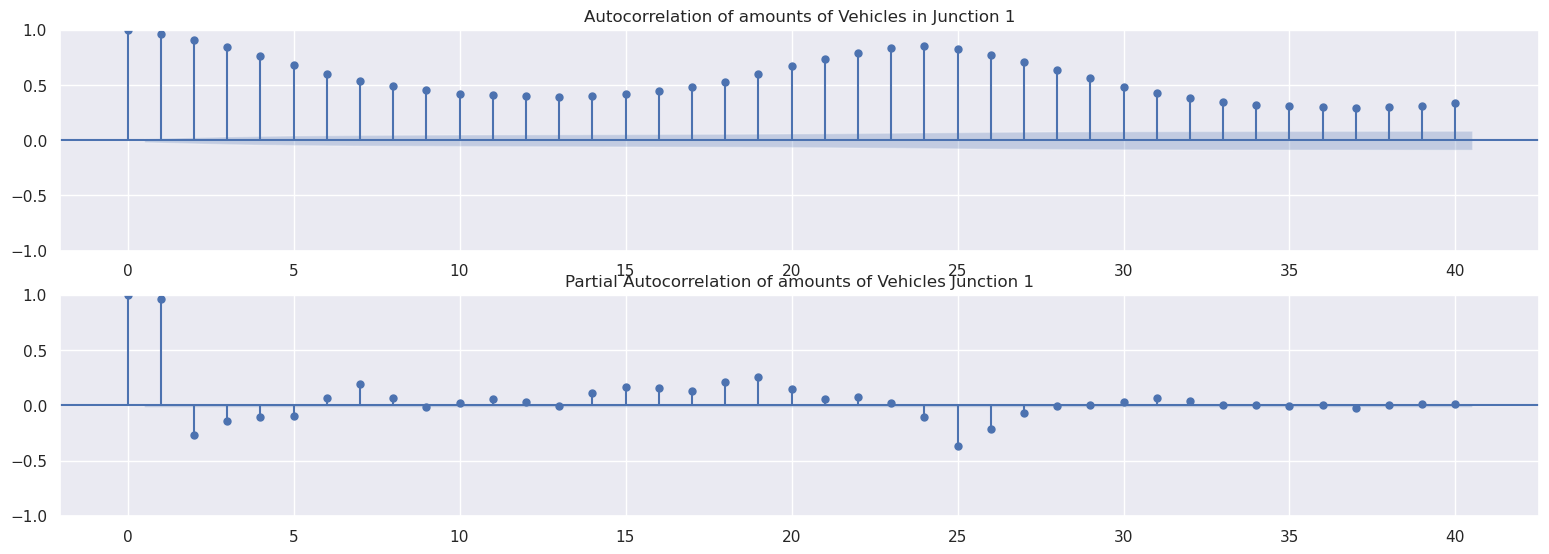

In [61]:
make_autocorrelation1(1)

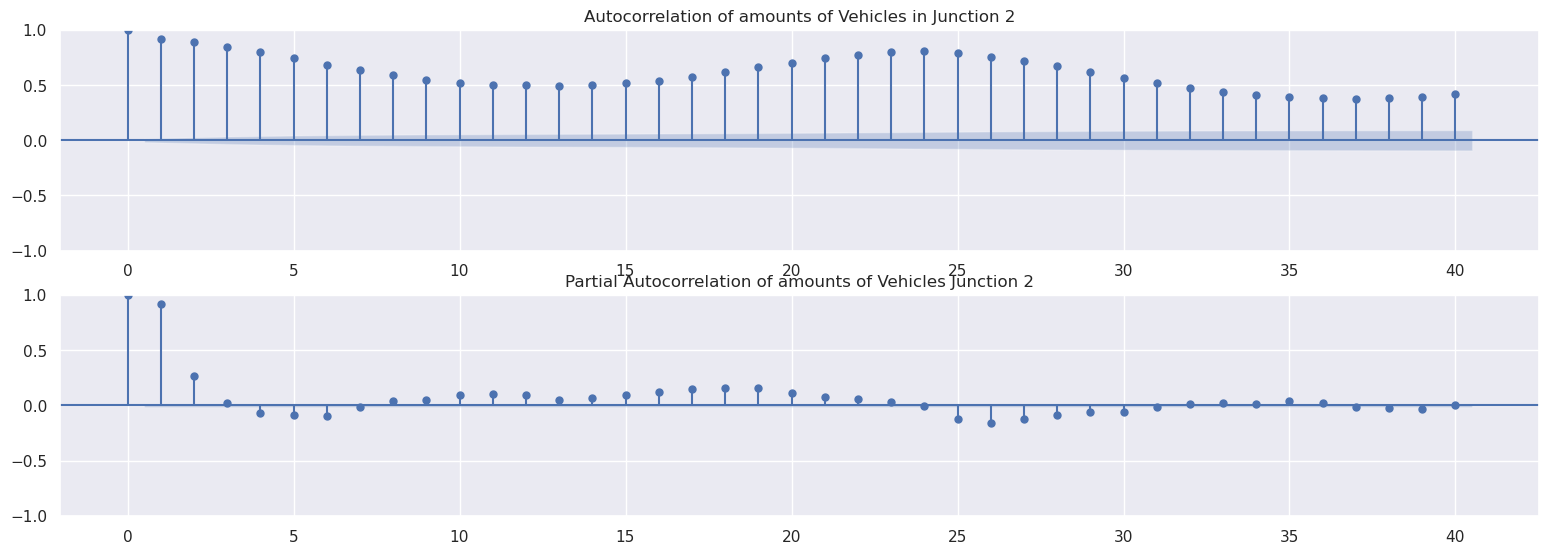

In [62]:
make_autocorrelation1(2)

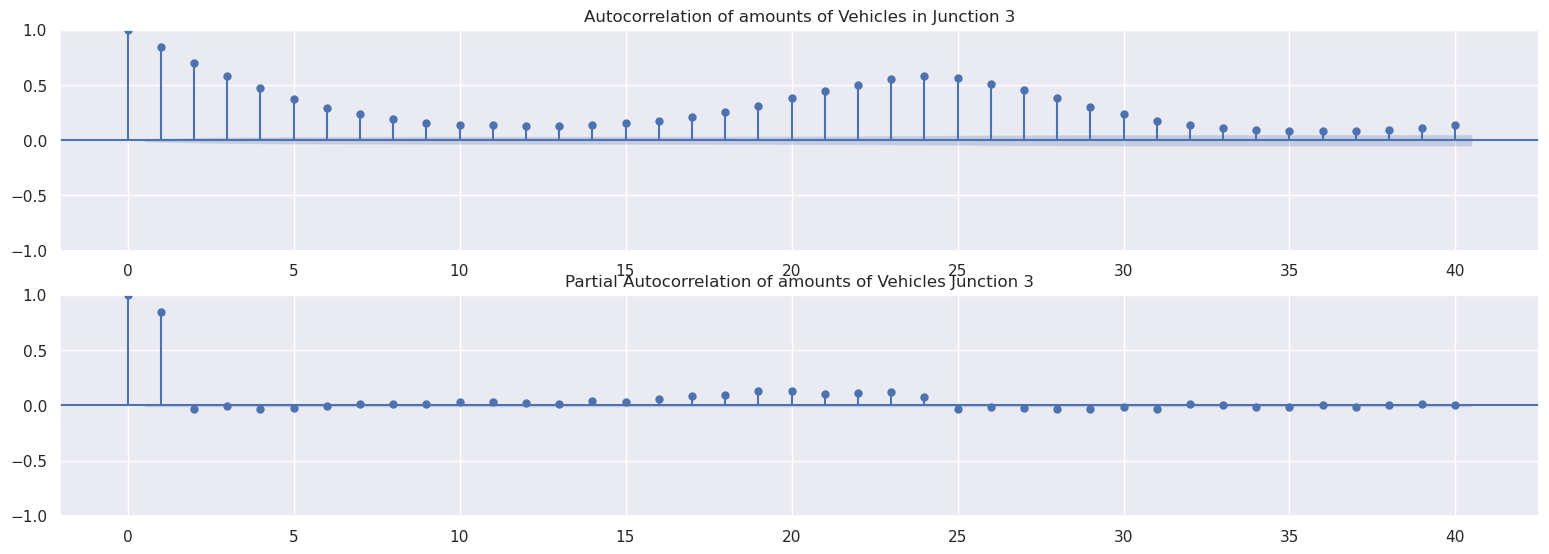

In [63]:
make_autocorrelation1(3)

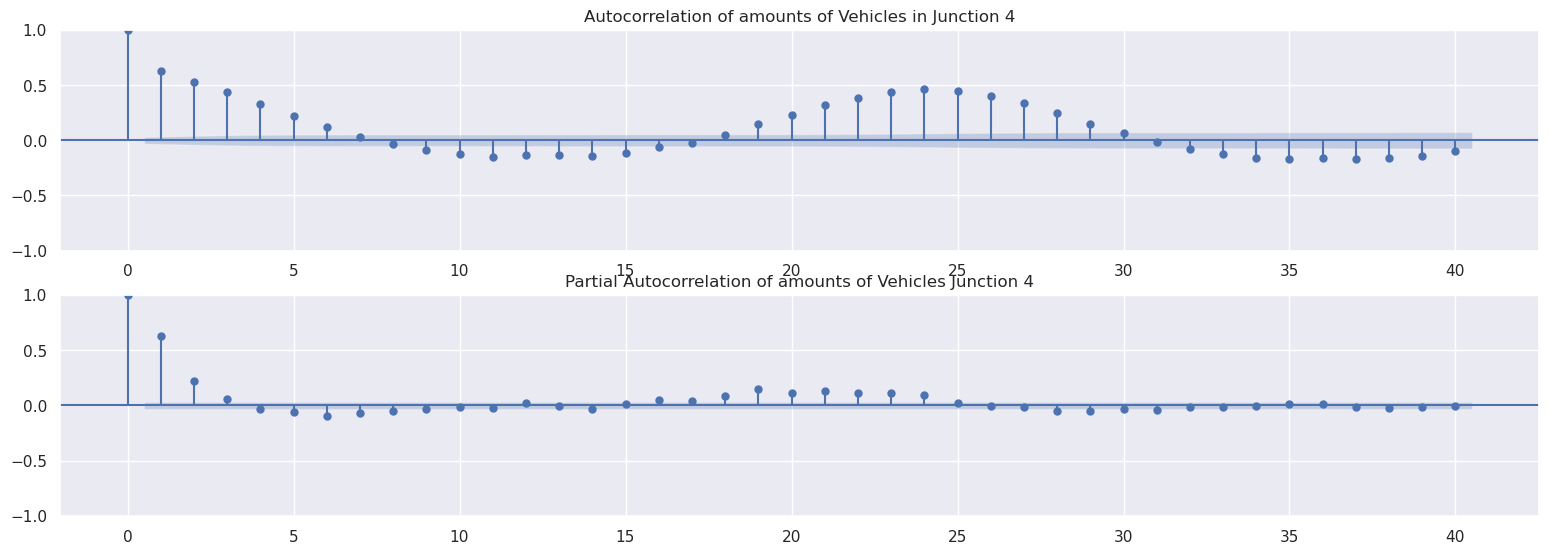

In [64]:
make_autocorrelation1(4)

Month has negative correlation with Year

The correlation of Vehicles and Year is equal to Vehicles and Hour

## Checking if data is stationary or not

In [65]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(data.Vehicles.dropna())
print('p-value: %f' % result[1])

p-value: 0.000000


In [66]:
result

(-7.518278111935738,
 3.851060199915222e-11,
 57,
 48062,
 {'1%': -3.430486066940443,
  '5%': -2.8616001387397922,
  '10%': -2.566802009871527},
 276495.72182130534)

p-value is almost 0 suggest data is stationary

# Modelling

### Preparing the data for modelling

In [67]:
#Standardize the data
standardization = lambda x: StandardScaler().fit_transform(x)

In [68]:
z_df = data.copy()
z_df['Vehicles'] = standardization(z_df.Vehicles.values.reshape(-1, 1))
z_df.head()

DateTime  Junction  Vehicles  Year  Month  Day  hour
0 2015-11-01 00:00:00         1 -0.375489  2015     11    1     0
1 2015-11-01 01:00:00         1 -0.471875  2015     11    1     1
2 2015-11-01 02:00:00         1 -0.616454  2015     11    1     2
3 2015-11-01 03:00:00         1 -0.761034  2015     11    1     3
4 2015-11-01 04:00:00         1 -0.664648  2015     11    1     4

In [69]:
standardization(data.Vehicles.values.reshape(-1, 1))

array([[-0.37548875],
       [-0.47187501],
       [-0.61645439],
       ...,
       [-0.32729563],
       [-0.03813687],
       [-0.52006813]])

In [70]:
z_df

DateTime  Junction  Vehicles  Year  Month  Day  hour
0     2015-11-01 00:00:00         1 -0.375489  2015     11    1     0
1     2015-11-01 01:00:00         1 -0.471875  2015     11    1     1
2     2015-11-01 02:00:00         1 -0.616454  2015     11    1     2
3     2015-11-01 03:00:00         1 -0.761034  2015     11    1     3
4     2015-11-01 04:00:00         1 -0.664648  2015     11    1     4
...                   ...       ...       ...   ...    ...  ...   ...
48115 2017-06-30 19:00:00         4 -0.568261  2017      6   30    19
48116 2017-06-30 20:00:00         4  0.347408  2017      6   30    20
48117 2017-06-30 21:00:00         4 -0.327296  2017      6   30    21
48118 2017-06-30 22:00:00         4 -0.038137  2017      6   30    22
48119 2017-06-30 23:00:00         4 -0.520068  2017      6   30    23

[48120 rows x 7 columns]

In [71]:
z_df.set_index('DateTime',inplace=True)

In [72]:
get_list_data(z_df)

[Empty DataFrame
 Columns: [Vehicles, Year, Month, Day, hour]
 Index: [],
                      Vehicles  Year  Month  Day  hour
 DateTime                                             
 2015-11-01 00:00:00 -0.375489  2015     11    1     0
 2015-11-01 01:00:00 -0.471875  2015     11    1     1
 2015-11-01 02:00:00 -0.616454  2015     11    1     2
 2015-11-01 03:00:00 -0.761034  2015     11    1     3
 2015-11-01 04:00:00 -0.664648  2015     11    1     4
 ...                       ...   ...    ...  ...   ...
 2017-06-30 19:00:00  3.961893  2017      6   30    19
 2017-06-30 20:00:00  3.528155  2017      6   30    20
 2017-06-30 21:00:00  3.238996  2017      6   30    21
 2017-06-30 22:00:00  2.949837  2017      6   30    22
 2017-06-30 23:00:00  2.660678  2017      6   30    23
 
 [14592 rows x 5 columns],
                      Vehicles  Year  Month  Day  hour
 DateTime                                             
 2015-11-01 00:00:00 -0.809227  2015     11    1     0
 2015-11-01 01:00

In [73]:
z_data = get_list_data(z_df)

In [74]:
z_data,len(z_data)

([Empty DataFrame
  Columns: [Vehicles, Year, Month, Day, hour]
  Index: [],
                       Vehicles  Year  Month  Day  hour
  DateTime                                             
  2015-11-01 00:00:00 -0.375489  2015     11    1     0
  2015-11-01 01:00:00 -0.471875  2015     11    1     1
  2015-11-01 02:00:00 -0.616454  2015     11    1     2
  2015-11-01 03:00:00 -0.761034  2015     11    1     3
  2015-11-01 04:00:00 -0.664648  2015     11    1     4
  ...                       ...   ...    ...  ...   ...
  2017-06-30 19:00:00  3.961893  2017      6   30    19
  2017-06-30 20:00:00  3.528155  2017      6   30    20
  2017-06-30 21:00:00  3.238996  2017      6   30    21
  2017-06-30 22:00:00  2.949837  2017      6   30    22
  2017-06-30 23:00:00  2.660678  2017      6   30    23
  
  [14592 rows x 5 columns],
                       Vehicles  Year  Month  Day  hour
  DateTime                                             
  2015-11-01 00:00:00 -0.809227  2015     11    1   

In [75]:
for i in z_data:
    print(i.head(1))

Empty DataFrame
Columns: [Vehicles, Year, Month, Day, hour]
Index: []
            Vehicles  Year  Month  Day  hour
DateTime                                    
2015-11-01 -0.375489  2015     11    1     0
            Vehicles  Year  Month  Day  hour
DateTime                                    
2015-11-01 -0.809227  2015     11    1     0
            Vehicles  Year  Month  Day  hour
DateTime                                    
2015-11-01 -0.664648  2015     11    1     0
            Vehicles  Year  Month  Day  hour
DateTime                                    
2017-01-01 -0.953806  2017      1    1     0


## Machine Learning Modelling

In [76]:
#Splitting the dataset into training and testing
def split_data(data, predict_features, test_size):
    X = data.drop(predict_features, axis=1).values
    y = data[predict_features].values
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=test_size)
    return Xtrain, Xtest, ytrain, ytest

In [77]:
#fitting the model on training data
def fit_model(ml_model, Xtrain, ytrain):
    ml_model.fit(Xtrain, ytrain)
    return ml_model

In [78]:
#predicting on test data
def predict_model(ml_model, Xtest):
    ypredict = ml_model.predict(Xtest)
    return ypredict

In [79]:
#root mean square for evaluation
def calculate_rmse(ytest, ypredict):
    rmse = mean_squared_error(ytest, ypredict, squared=False)
    return rmse

In [80]:
#accuracy or r2_score wrt predicting data
def calculate_r2_score(ytest, ypredict):
    r2 = r2_score(ytest, ypredict)
    return r2

In [81]:
def plot_feature_importance(ml_model, features, ax):
    feature_importances = ml_model.feature_importances_
    data = pd.DataFrame(pd.Series(feature_importances, index=features).nlargest(10)).reset_index()
    data.columns = ['Features', 'Value']
    g = sns.barplot(data=data, x='Features', y='Value', ax=ax)
    for p in g.patches:
        ax.annotate(
            format(p.get_height(), '.2f'),
            (p.get_x() + p.get_width() / 2, p.get_height() + 0.02),
            ha='center', va='center', weight='bold', fontsize=9
        )
    ax.set_title(f'Plot of Feature Importance', fontsize=12)
    ax.grid(True, ls='-.', alpha=0.7)
    ax.set_ylim(0, 1)

In [82]:
models1 = [LinearRegression() for i in range(1, 5)]

In [83]:
models = [RandomForestRegressor() for i in range(1, 5)]

In [84]:
models2 = ['ARIMA' for i in range(1, 5)] 

In [85]:
#function to perform all the task for modelling
def make_metrics(models, data, predict_features, test_size):
    metrics = []
    for i in range(1,5):
        Xtrain, Xtest, ytrain, ytest = split_data(data[i], predict_features, test_size)
        ml_model = fit_model(models[i-1], Xtrain, ytrain)
        ypredict = predict_model(ml_model, Xtest)
        rmse = calculate_rmse(ytest, ypredict)
        r2 = calculate_r2_score(ytest, ypredict)
        metrics.append({'name': models[i-1].__class__.__name__, 'r2': r2, 'rmse': rmse})
    average_r2 = np.mean([metric['r2'] for metric in metrics])
    total_rmse = np.sum([metric['rmse'] for metric in metrics])
    metrics.append({'name': 'average R2 and sum RMSE', 'r2': average_r2, 'rmse': total_rmse})
    return pd.DataFrame(metrics)

In [86]:
metrics1 = make_metrics(models1, z_data, 'Vehicles', test_size=0.25)
metrics1

name        r2      rmse
0         LinearRegression  0.639381  0.679402
1         LinearRegression  0.523564  0.248859
2         LinearRegression  0.253155  0.443440
3         LinearRegression  0.190211  0.152812
4  average R2 and sum RMSE  0.401578  1.524512

In [87]:
metrics = make_metrics(models, z_data, 'Vehicles', test_size=0.25)
metrics

name        r2      rmse
0    RandomForestRegressor  0.937922  0.279633
1    RandomForestRegressor  0.853689  0.138351
2    RandomForestRegressor  0.715861  0.269976
3    RandomForestRegressor  0.543947  0.115579
4  average R2 and sum RMSE  0.762855  0.803540

In [88]:
t1=split_data(data1[2], 'Vehicles', test_size=0.25)

In [89]:
t1

(array([[2016,    2,   14,    2],
        [2016,   10,   28,   23],
        [2016,   10,    4,    5],
        ...,
        [2017,    3,   11,    1],
        [2016,    3,   26,   21],
        [2017,    2,   22,    7]]),
 array([[2017,    3,    4,   11],
        [2017,    6,   23,   21],
        [2016,    9,   26,   22],
        ...,
        [2017,    1,   25,   12],
        [2015,   11,    1,    9],
        [2016,    1,   30,    3]]),
 array([ 8, 16, 11, ..., 20,  6, 22]),
 array([14, 32, 17, ..., 22,  3, 11]))

In [90]:
len(t1)

4

In [91]:
len(t1[1][:,0]==2015)

3648

## Creation of Lag data

In [92]:
lag_df = data.copy()
for i in range(1, 3):
    lag_df[f'Vehicles_lag_{i}'] = data.Vehicles.shift(i)

In [93]:
lag_df

DateTime  Junction  Vehicles  Year  Month  Day  hour  \
0     2015-11-01 00:00:00         1        15  2015     11    1     0   
1     2015-11-01 01:00:00         1        13  2015     11    1     1   
2     2015-11-01 02:00:00         1        10  2015     11    1     2   
3     2015-11-01 03:00:00         1         7  2015     11    1     3   
4     2015-11-01 04:00:00         1         9  2015     11    1     4   
...                   ...       ...       ...   ...    ...  ...   ...   
48115 2017-06-30 19:00:00         4        11  2017      6   30    19   
48116 2017-06-30 20:00:00         4        30  2017      6   30    20   
48117 2017-06-30 21:00:00         4        16  2017      6   30    21   
48118 2017-06-30 22:00:00         4        22  2017      6   30    22   
48119 2017-06-30 23:00:00         4        12  2017      6   30    23   

       Vehicles_lag_1  Vehicles_lag_2  
0                 NaN             NaN  
1                15.0             NaN  
2                13.0            15.0  
3                10.0            13.0  
4                 7.0            10.0  
...               ...             ...  
48115            17.0            16.0  
48116            11.0            17.0  
48117            30.0            11.0  
48118            16.0            30.0  
48119            22.0            16.0  

[48120 rows x 9 columns]

In [94]:
# drop all rows with nan, because lag data cause nan
lag_df.dropna(inplace=True)
lag_df.head()

DateTime  Junction  Vehicles  Year  Month  Day  hour  \
2 2015-11-01 02:00:00         1        10  2015     11    1     2   
3 2015-11-01 03:00:00         1         7  2015     11    1     3   
4 2015-11-01 04:00:00         1         9  2015     11    1     4   
5 2015-11-01 05:00:00         1         6  2015     11    1     5   
6 2015-11-01 06:00:00         1         9  2015     11    1     6   

   Vehicles_lag_1  Vehicles_lag_2  
2            13.0            15.0  
3            10.0            13.0  
4             7.0            10.0  
5             9.0             7.0  
6             6.0             9.0

In [95]:
lag_df.set_index('DateTime',inplace=True)

In [96]:
lag_df.head()

Junction  Vehicles  Year  Month  Day  hour  \
DateTime                                                          
2015-11-01 02:00:00         1        10  2015     11    1     2   
2015-11-01 03:00:00         1         7  2015     11    1     3   
2015-11-01 04:00:00         1         9  2015     11    1     4   
2015-11-01 05:00:00         1         6  2015     11    1     5   
2015-11-01 06:00:00         1         9  2015     11    1     6   

                     Vehicles_lag_1  Vehicles_lag_2  
DateTime                                             
2015-11-01 02:00:00            13.0            15.0  
2015-11-01 03:00:00            10.0            13.0  
2015-11-01 04:00:00             7.0            10.0  
2015-11-01 05:00:00             9.0             7.0  
2015-11-01 06:00:00             6.0             9.0

In [97]:
lag_data = get_list_data(lag_df, drop=['Year'])

In [98]:
for i in lag_data:
    print(i.head(1))

Empty DataFrame
Columns: [Vehicles, Month, Day, hour, Vehicles_lag_1, Vehicles_lag_2]
Index: []
                     Vehicles  Month  Day  hour  Vehicles_lag_1  \
DateTime                                                          
2015-11-01 02:00:00        10     11    1     2            13.0   

                     Vehicles_lag_2  
DateTime                             
2015-11-01 02:00:00            15.0  
            Vehicles  Month  Day  hour  Vehicles_lag_1  Vehicles_lag_2
DateTime                                                              
2015-11-01         6     11    1     0            78.0            84.0
            Vehicles  Month  Day  hour  Vehicles_lag_1  Vehicles_lag_2
DateTime                                                              
2015-11-01         9     11    1     0            27.0            29.0
            Vehicles  Month  Day  hour  Vehicles_lag_1  Vehicles_lag_2
DateTime                                                              
2017-01-01         3

In [99]:
metrics_lag_data1 = make_metrics(models1, lag_data, 'Vehicles', test_size=0.25)
metrics_lag_data1

name        r2       rmse
0         LinearRegression  0.938712   5.680101
1         LinearRegression  0.852259   2.797654
2         LinearRegression  0.710564   5.861435
3         LinearRegression  0.471266   2.492715
4  average R2 and sum RMSE  0.743200  16.831904

In [100]:
metrics_lag_data = make_metrics(models, lag_data, 'Vehicles', test_size=0.25)
metrics_lag_data

name        r2       rmse
0    RandomForestRegressor  0.969063   4.024417
1    RandomForestRegressor  0.879267   2.511201
2    RandomForestRegressor  0.775429   5.176349
3    RandomForestRegressor  0.463266   2.430044
4  average R2 and sum RMSE  0.771756  14.142010

## ARIMA and SARIMAX

In [101]:
#pip install pmdarima

In [102]:
#from statsmodels.tsa.statespace.sarimax import SARIMAX
#import pmdarima as pm

In [103]:
#splitting lag data into training and testing 
#for i in range(1,5):
 #   Xtrain, Xtest, ytrain, ytest=split_data(lag_data[i], 'Vehicles',test_size=0.25)

In [104]:
#Xtrain, Xtest, ytrain, ytest

In [105]:
#metrics for evaluation
'''def model_metrics_out(y_test,forecast):
    rmse = calculate_rmse(y_test, forecast)
    r2 = calculate_r2_score(y_test, forecast)
    return r2,rmse'''
    

'def model_metrics_out(y_test,forecast):\n    rmse = calculate_rmse(y_test, forecast)\n    r2 = calculate_r2_score(y_test, forecast)\n    return r2,rmse'

In [106]:
#SARIMAX modelling
'''metrics=[]
for i in range(1,5):
    X_train, X_test, y_train, y_test=split_data(lag_data[i], 'Vehicles',test_size=0.25)
    results = pm.auto_arima(y_train, #data
                        d=1, # non-seasonal difference order
                        start_p=0, # initial guess for p
                        start_q=0, # initial guess for q
                        max_p=2, # max value of p to test
                        max_q=2, # max value of q to test
                        exogenous= X_train, #including the exogenous variables
                        seasonal=True, # is the time series seasonal? YES
                        m = 24, # the seasonal period
                        #D=1, # seasonal difference order
                        start_P=1, # initial guess for P
                        start_Q=1, # initial guess for Q
                        max_P=1, # max value of P to test
                        max_Q=1, # max value of Q to test
                        information_criterion='aic', # used to select best model
                        trace=True, # print results whilst training
                        error_action='ignore', # ignore orders that don't work
                        stepwise=True, # apply intelligent order search
                        )
    model_opt = SARIMAX(y_train, order=(2,1,0), seasonal_order=(0, 0, 1, 24), exog = X_train, trend='c')
    results = model_opt.fit()
    _ = results.plot_diagnostics(figsize=(12, 7))
    forecast = results.forecast(steps=X_test.shape[0], exog=X_test)
    r2,rmse=model_metrics_out(y_test,forecast)
    metrics.append({'name': models2[i-1], 'r2': r2, 'rmse': rmse})
average_r2 = np.mean([metric['r2'] for metric in metrics])
total_rmse = np.sum([metric['rmse'] for metric in metrics])
metrics.append({'name': 'average R2 and sum RMSE', 'r2': average_r2, 'rmse': total_rmse})
output_metric = pd.DataFrame(metrics)'''
    

"metrics=[]\nfor i in range(1,5):\n    X_train, X_test, y_train, y_test=split_data(lag_data[i], 'Vehicles',test_size=0.25)\n    results = pm.auto_arima(y_train, #data\n                        d=1, # non-seasonal difference order\n                        start_p=0, # initial guess for p\n                        start_q=0, # initial guess for q\n                        max_p=2, # max value of p to test\n                        max_q=2, # max value of q to test\n                        exogenous= X_train, #including the exogenous variables\n                        seasonal=True, # is the time series seasonal? YES\n                        m = 24, # the seasonal period\n                        #D=1, # seasonal difference order\n                        start_P=1, # initial guess for P\n                        start_Q=1, # initial guess for Q\n                        max_P=1, # max value of P to test\n                        max_Q=1, # max value of Q to test\n                        informati

In [107]:
#output_metric

In [108]:
#summary=results.summary()
#summary

In [109]:
#model_opt = SARIMAX(y_train, order=(2,1,0), seasonal_order=(0, 0, 1, 24), exog = X_train, trend='c')

In [110]:
#model_opt

In [111]:
#results = model_opt.fit()

In [112]:
#plot_list=[]

#plot_list.append(results.plot_diagnostics(figsize=(12, 7)))

In [113]:
#plot_list

In [114]:
#X_test,X_test.shape

In [115]:
#X_train,X_train.shape

In [116]:
#forecast = results.forecast(steps=3647, exog=X_test)

In [117]:
#forecast

In [118]:
#rmse = calculate_rmse(y_test, forecast)
#r2 = calculate_r2_score(y_test, forecast)

In [119]:
#rmse

In [120]:
#r2

## Deep Learning models

In [121]:
lag_data[1]

Vehicles  Month  Day  hour  Vehicles_lag_1  \
DateTime                                                          
2015-11-01 02:00:00        10     11    1     2            13.0   
2015-11-01 03:00:00         7     11    1     3            10.0   
2015-11-01 04:00:00         9     11    1     4             7.0   
2015-11-01 05:00:00         6     11    1     5             9.0   
2015-11-01 06:00:00         9     11    1     6             6.0   
...                       ...    ...  ...   ...             ...   
2017-06-30 19:00:00       105      6   30    19            95.0   
2017-06-30 20:00:00        96      6   30    20           105.0   
2017-06-30 21:00:00        90      6   30    21            96.0   
2017-06-30 22:00:00        84      6   30    22            90.0   
2017-06-30 23:00:00        78      6   30    23            84.0   

                     Vehicles_lag_2  
DateTime                             
2015-11-01 02:00:00            15.0  
2015-11-01 03:00:00            13.0  
2015-11-01 04:00:00            10.0  
2015-11-01 05:00:00             7.0  
2015-11-01 06:00:00             9.0  
...                             ...  
2017-06-30 19:00:00            90.0  
2017-06-30 20:00:00            95.0  
2017-06-30 21:00:00           105.0  
2017-06-30 22:00:00            96.0  
2017-06-30 23:00:00            90.0  

[14590 rows x 6 columns]

In [122]:
def data_cleaning(temp_df):
    temp_df.drop(['Month', 'Day', 'hour'],axis=1, inplace=True)
    #temp_df.set_index('DateTime', inplace=True)
    return temp_df

In [123]:
def total_duration_sec(temp_df):
    temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
    return temp_df

In [124]:
def temp_feature_creation(temp_df):
    day = 60*60*24
    year = 365.2425*day
    temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2* np.pi / day))
    temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
    temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
    temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
    temp_df = temp_df.drop('Seconds', axis=1)
    return temp_df

In [125]:
def df_to_X_y2(df, window_size=6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [126]:
def train_test_val_split(X2,y2):
    X2_train, y2_train = X2[:int(.6*(len(X2)))], y2[:int(.6*(len(y2)))]
    X2_val, y2_val = X2[int(.6*(len(X2))):int(.8*(len(X2)))], y2[int(.6*(len(y2))):int(.8*(len(y2)))]
    X2_test, y2_test = X2[int(.8*len(X2)):], y2[int(.8*len(y2)):]
    return X2_train,X2_val,X2_test,y2_train,y2_val,y2_test

In [127]:
def preprocess(X):
    temp_training_mean = np.mean(X_train[:, :, 0])
    temp_training_std = np.std(X_train[:, :, 0])
    X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
    return X

In [128]:
def model_creation(model_name):
    if model_name=='LSTM':
        model = Sequential()
        model.add(InputLayer((6, 7)))
        model.add(LSTM(64))
        model.add(BatchNormalization())
        model.add(Dense(8, 'relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1, 'linear'))
    elif model_name=='GRU':
        model = Sequential()
        model.add(InputLayer((6, 7)))
        model.add(LSTM(64))
        model.add(Dense(32, 'relu'))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())
        model.add(Dense(8, 'relu'))
        model.add(Dropout(0.3))
        model.add(Dense(1, 'linear'))
    return model

In [129]:
from keras.callbacks import EarlyStopping
def model_fitting(model):
    cp4 = ModelCheckpoint('model4/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0009), metrics=[RootMeanSquaredError()])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[cp4, es])
    return history

In [130]:
def history_loss_mse(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_mse = history.history['root_mean_squared_error']
    val_mse = history.history['val_root_mean_squared_error']
    return train_loss,val_loss,train_mse,val_mse

In [131]:
def predict_model(model, Xtest):
    y_predict = model.predict(Xtest)
    return y_predict

In [132]:
def plotting_loss(train_loss,val_loss):
    # Plot the training and validation loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [133]:
def plotting_mse(train_mse,val_mse):
    # Plot the training and validation loss
    plt.plot(train_mse, label='Training MSE')
    plt.plot(val_mse, label='Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

In [134]:
def plot_predictions(X, y, start=0, end=None):
    end=len(X)
    predictions = y.flatten()
    df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':X})
    plt.figure(figsize=(14,5))
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.legend(df)
    plt.show()
    return df

## LSTM

In [135]:
training_loss= []
validation_loss= []
training_mse= []
validation_mse= []
test=[]
prediction=[]
for i in range(1,5):
    temp_df=lag_data[i].copy()
    cleaned_data=data_cleaning(temp_df)
    sec_data=total_duration_sec(cleaned_data)
    final_data=temp_feature_creation(sec_data)
    X,y= df_to_X_y2(final_data)
    X_train,X_val,X_test,y_train,y_val,y_test = train_test_val_split(X,y)
    X_train=preprocess(X_train)
    X_val = preprocess(X_val)
    X_test= preprocess(X_test)
    model = model_creation('LSTM')
    history = model_fitting(model)
    y_predict=predict_model(model, X_test)
    train_loss,val_loss,train_mse,val_mse = history_loss_mse(history)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    training_mse.append(train_mse)
    validation_mse.append(val_mse)
    test.append(y_test)
    prediction.append(y_predict)

Epoch 1/30
274/274 [==============================] - 19s 26ms/step - loss: 514.9443 - root_mean_squared_error: 22.6924 - val_loss: 987.3588 - val_root_mean_squared_error: 31.4223
Epoch 2/30
274/274 [==============================] - 6s 23ms/step - loss: 215.2763 - root_mean_squared_error: 14.6723 - val_loss: 472.3242 - val_root_mean_squared_error: 21.7330
Epoch 3/30
274/274 [==============================] - 2s 7ms/step - loss: 179.1339 - root_mean_squared_error: 13.3841 - val_loss: 879.2477 - val_root_mean_squared_error: 29.6521
Epoch 4/30
274/274 [==============================] - 2s 7ms/step - loss: 145.3112 - root_mean_squared_error: 12.0545 - val_loss: 4674.0674 - val_root_mean_squared_error: 68.3671
Epoch 5/30
274/274 [==============================] - 2s 7ms/step - loss: 118.3975 - root_mean_squared_error: 10.8811 - val_loss: 16981.9258 - val_root_mean_squared_error: 130.3147
Epoch 5: early stopping
92/92 [==============================] - 1s 3ms/step
Epoch 1/30
274/274 [======

In [136]:
final_data

Vehicles  Vehicles_lag_1  Vehicles_lag_2       Day sin  \
DateTime                                                                      
2017-01-01 00:00:00         3            39.0            26.0  2.504006e-13   
2017-01-01 01:00:00         1             3.0            39.0  2.588190e-01   
2017-01-01 02:00:00         4             1.0             3.0  5.000000e-01   
2017-01-01 03:00:00         4             4.0             1.0  7.071068e-01   
2017-01-01 04:00:00         2             4.0             4.0  8.660254e-01   
...                       ...             ...             ...           ...   
2017-06-30 19:00:00        11            17.0            16.0 -9.659258e-01   
2017-06-30 20:00:00        30            11.0            17.0 -8.660254e-01   
2017-06-30 21:00:00        16            30.0            11.0 -7.071068e-01   
2017-06-30 22:00:00        22            16.0            30.0 -5.000000e-01   
2017-06-30 23:00:00        12            22.0            16.0 -2.588190e-01   

                      Day cos  Year sin  Year cos  
DateTime                                           
2017-01-01 00:00:00  1.000000  0.010364  0.999946  
2017-01-01 01:00:00  0.965926  0.011081  0.999939  
2017-01-01 02:00:00  0.866025  0.011798  0.999930  
2017-01-01 03:00:00  0.707107  0.012515  0.999922  
2017-01-01 04:00:00  0.500000  0.013231  0.999912  
...                       ...       ...       ...  
2017-06-30 19:00:00  0.258819  0.021108 -0.999777  
2017-06-30 20:00:00  0.500000  0.020391 -0.999792  
2017-06-30 21:00:00  0.707107  0.019674 -0.999806  
2017-06-30 22:00:00  0.866025  0.018958 -0.999820  
2017-06-30 23:00:00  0.965926  0.018241 -0.999834  

[4344 rows x 7 columns]

In [137]:
X_test.shape

(868, 6, 7)

for junction 1:


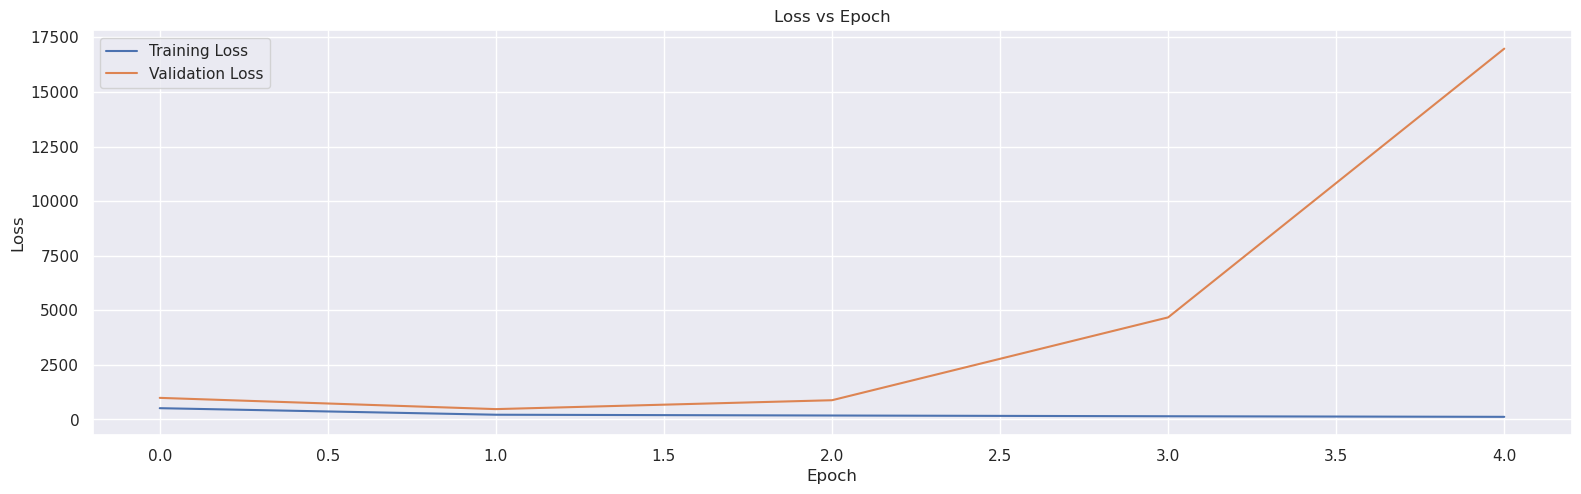

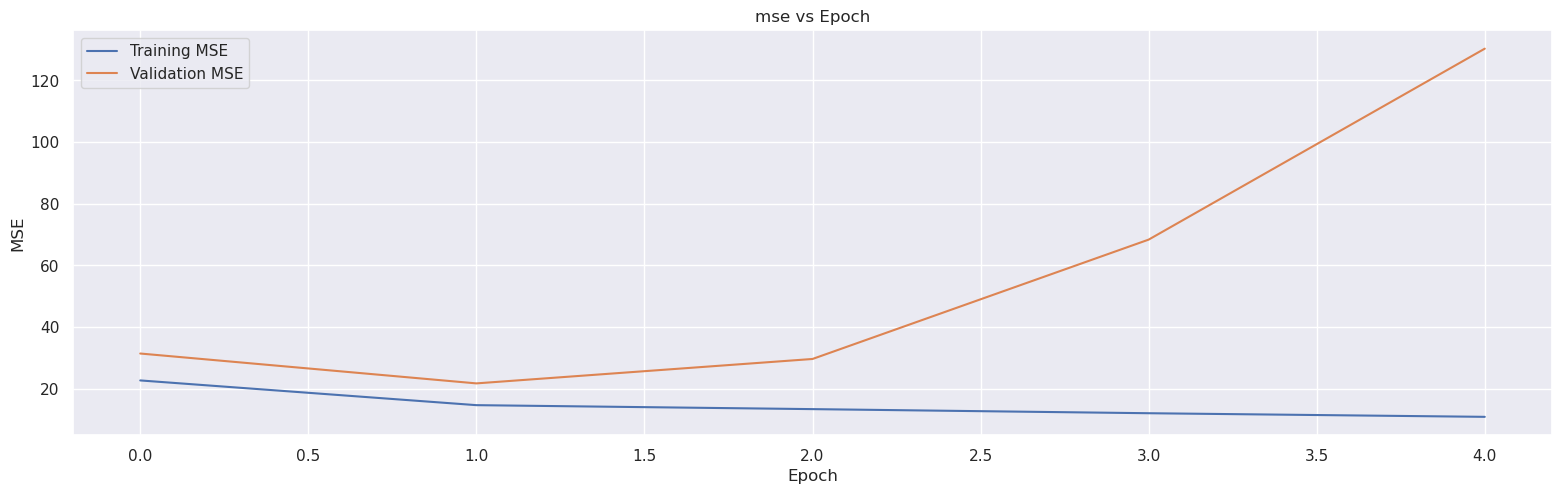

for junction 2:


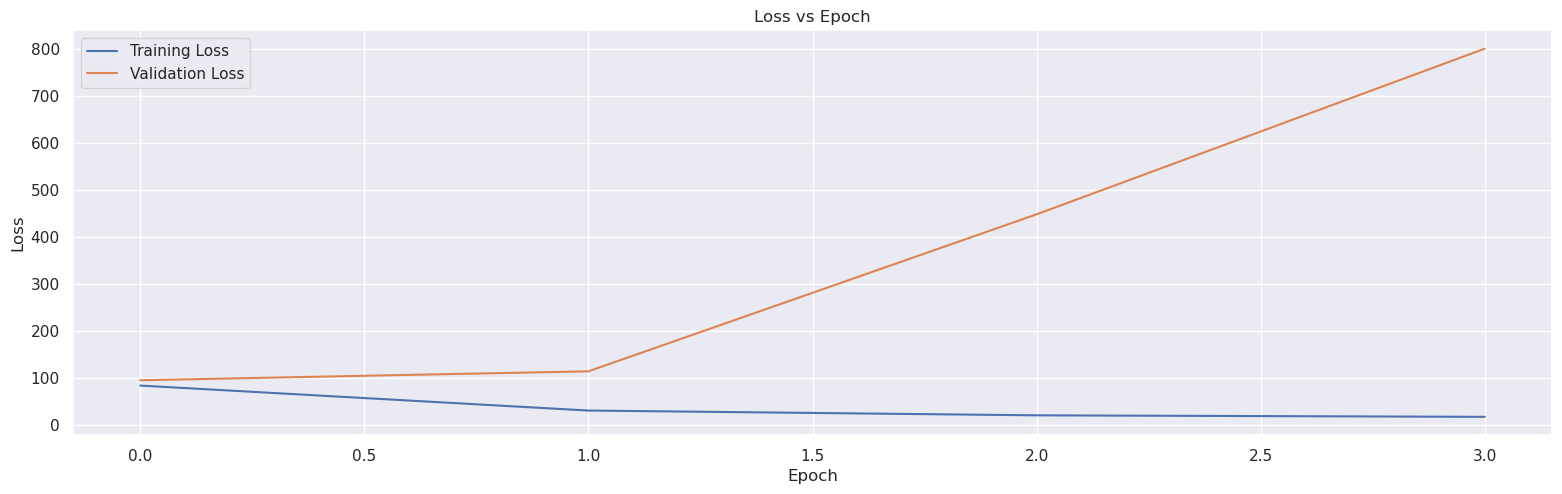

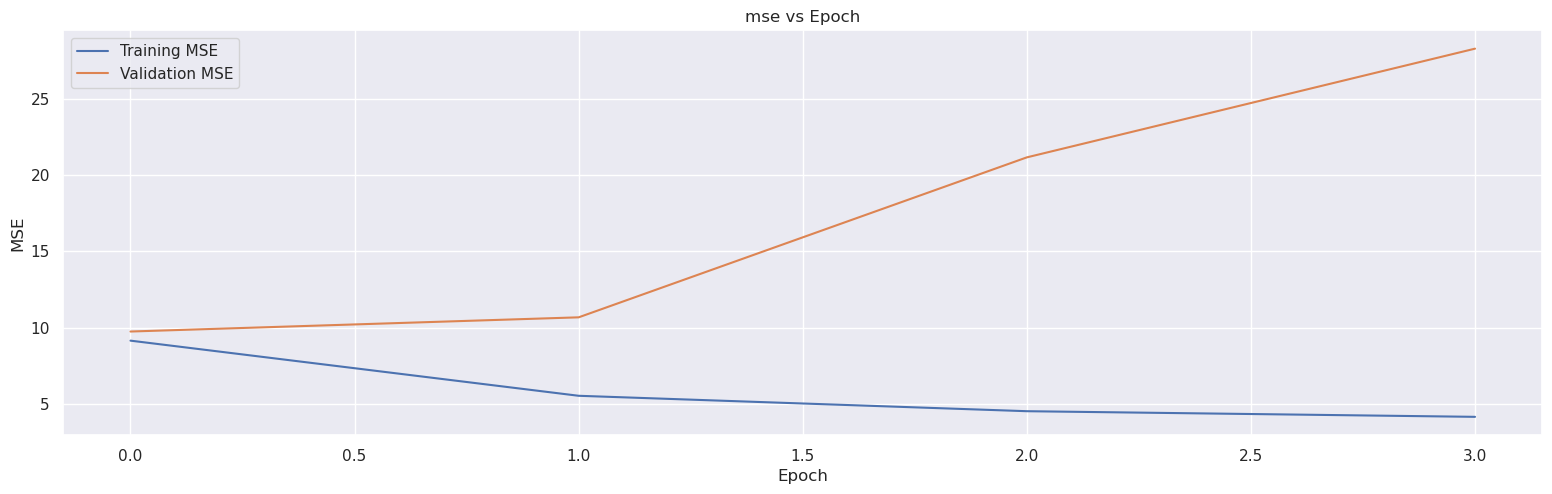

for junction 3:


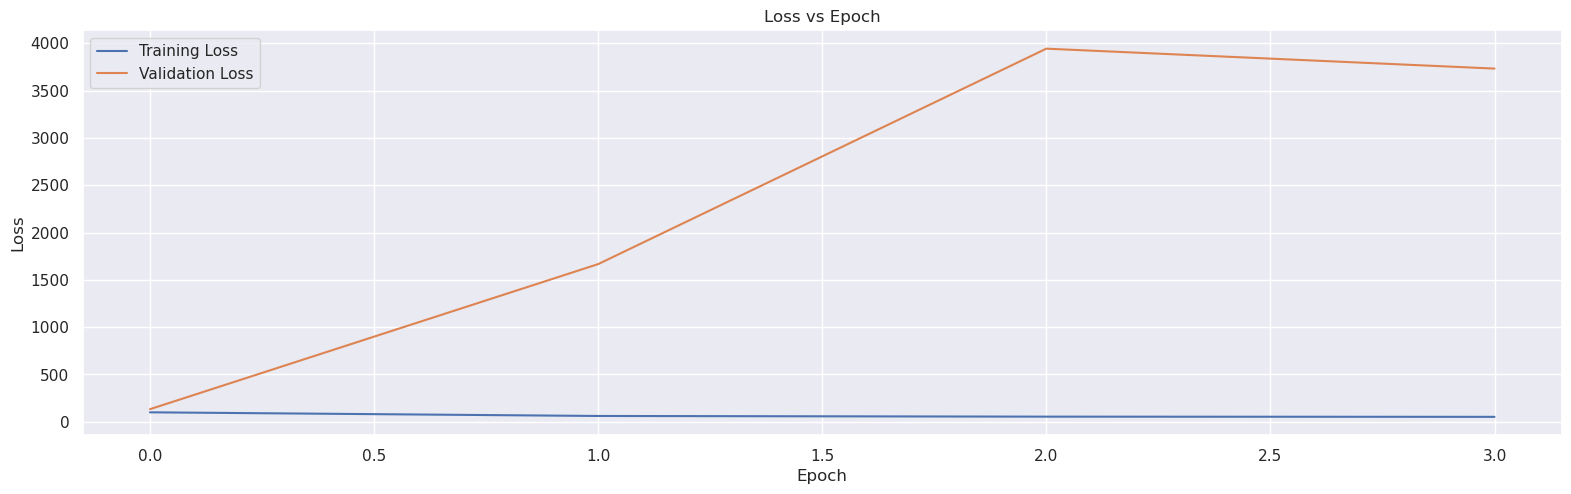

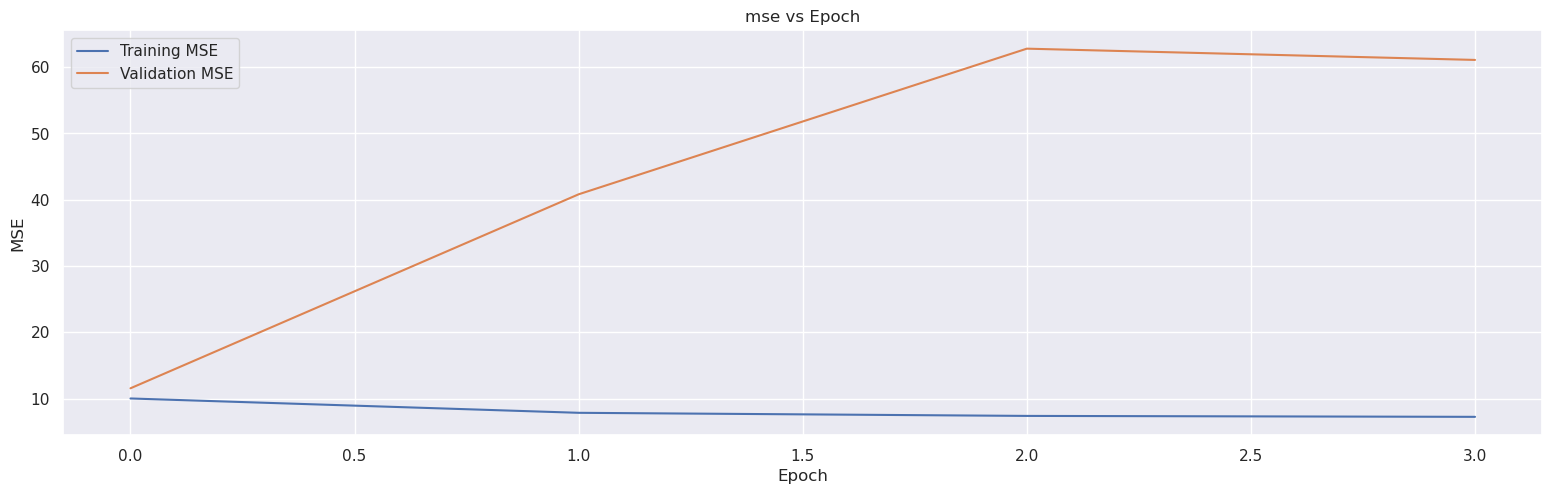

for junction 4:


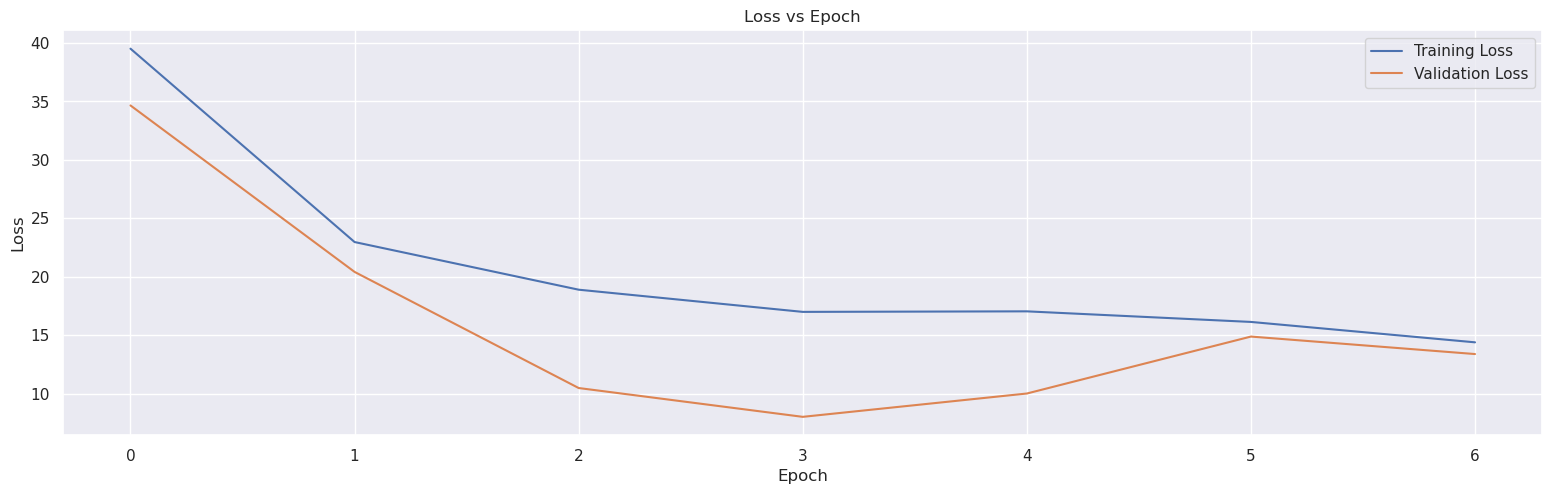

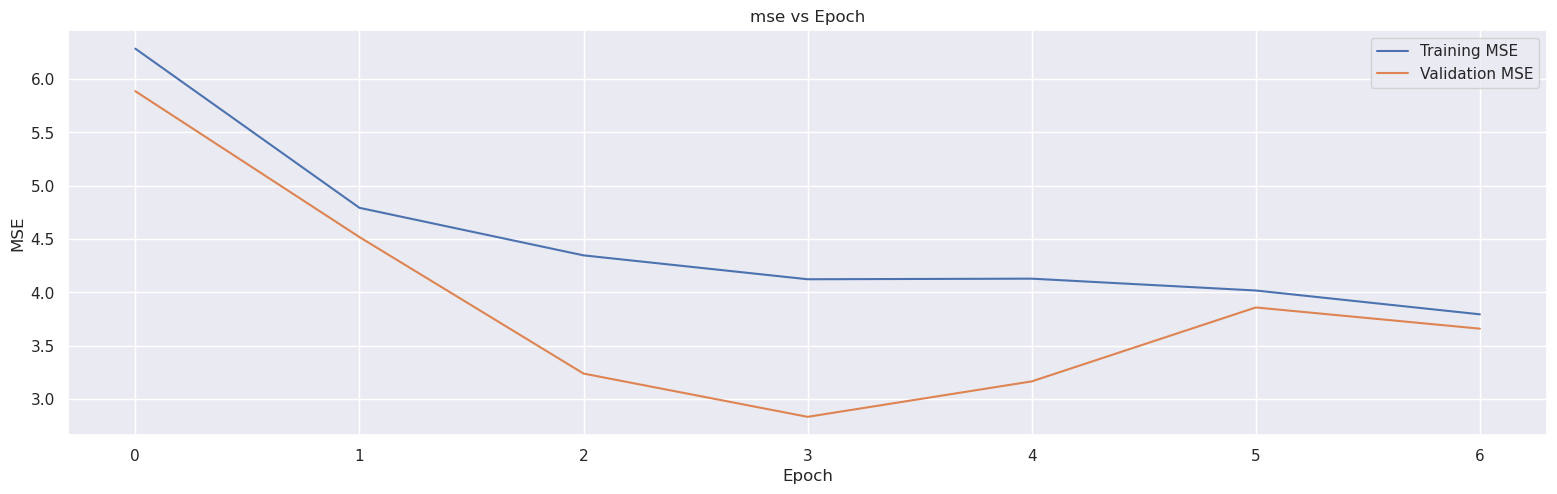

In [138]:
for i in range(1,5):
    print(f"for junction {i}:")
    plt.title('Loss vs Epoch')
    plotting_loss(training_loss[i-1],validation_loss[i-1])
    plt.title('mse vs Epoch')
    plotting_mse(training_mse[i-1],validation_mse[i-1])

for junction 1:


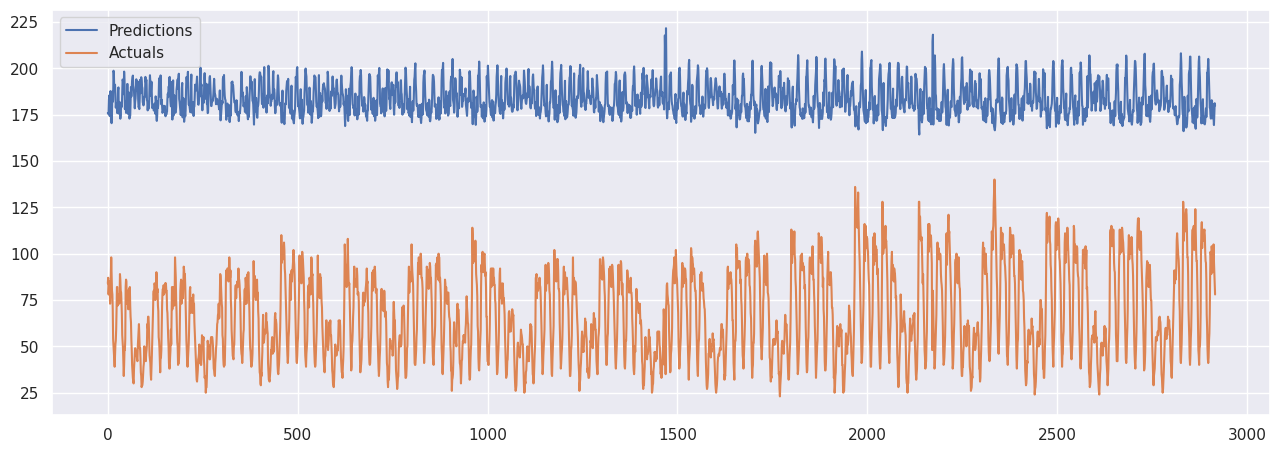

for junction 2:


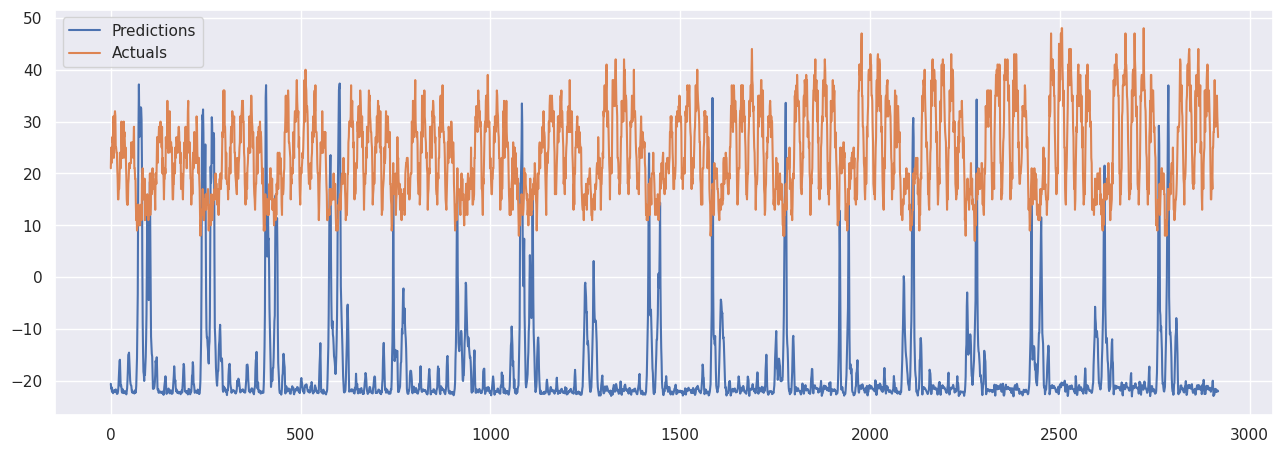

for junction 3:


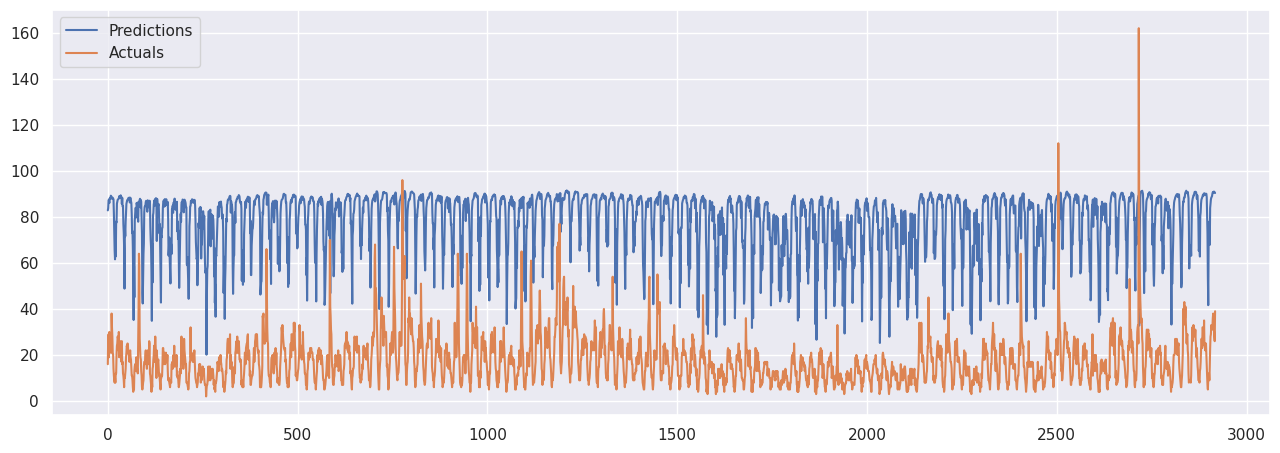

for junction 4:


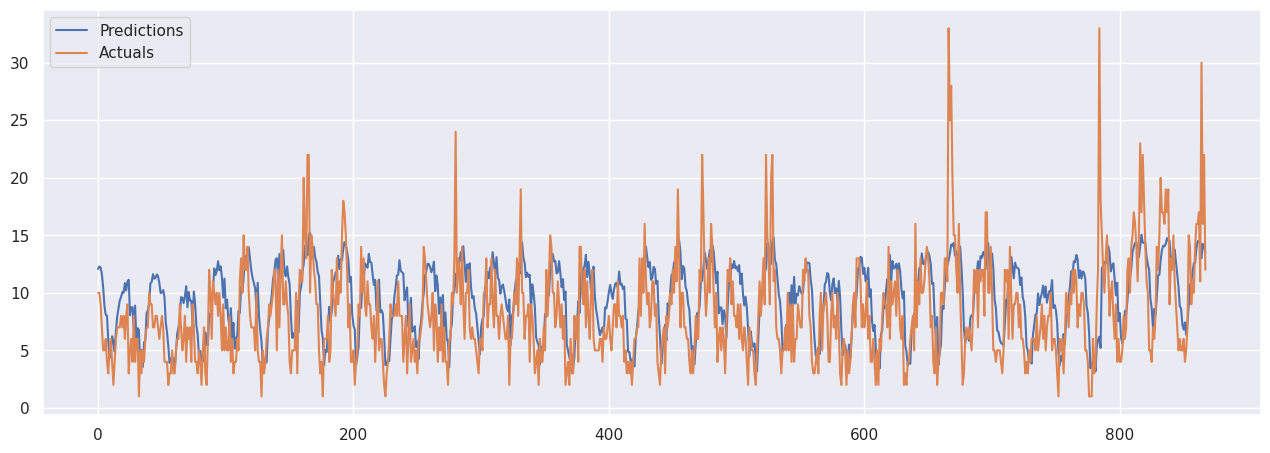

In [139]:
for i in range(1,5):
    print(f"for junction {i}:")
    plot_predictions(test[i-1], prediction[i-1])

## GRU

In [140]:
training_loss= []
validation_loss= []
training_mse= []
validation_mse= []
test=[]
prediction=[]
for i in range(1,5):
    temp_df=lag_data[i].copy()
    cleaned_data=data_cleaning(temp_df)
    sec_data=total_duration_sec(cleaned_data)
    final_data=temp_feature_creation(sec_data)
    X,y= df_to_X_y2(final_data)
    X_train,X_val,X_test,y_train,y_val,y_test = train_test_val_split(X,y)
    X_train=preprocess(X_train)
    X_val = preprocess(X_val)
    X_test= preprocess(X_test)
    model = model_creation('GRU')
    history = model_fitting(model)
    y_predict=predict_model(model, X_test)
    train_loss,val_loss,train_mse,val_mse = history_loss_mse(history)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    training_mse.append(train_mse)
    validation_mse.append(val_mse)
    test.append(y_test)
    prediction.append(y_predict)

Epoch 1/30
274/274 [==============================] - 11s 28ms/step - loss: 1004.3871 - root_mean_squared_error: 31.6921 - val_loss: 878.4975 - val_root_mean_squared_error: 29.6395
Epoch 2/30
274/274 [==============================] - 2s 8ms/step - loss: 269.1670 - root_mean_squared_error: 16.4063 - val_loss: 1264.6080 - val_root_mean_squared_error: 35.5613
Epoch 3/30
274/274 [==============================] - 2s 7ms/step - loss: 181.9755 - root_mean_squared_error: 13.4898 - val_loss: 13411.7900 - val_root_mean_squared_error: 115.8093
Epoch 4/30
274/274 [==============================] - 2s 7ms/step - loss: 178.8655 - root_mean_squared_error: 13.3741 - val_loss: 33241.4297 - val_root_mean_squared_error: 182.3223
Epoch 4: early stopping
92/92 [==============================] - 1s 2ms/step
Epoch 1/30
274/274 [==============================] - 10s 27ms/step - loss: 99.1475 - root_mean_squared_error: 9.9573 - val_loss: 104.0291 - val_root_mean_squared_error: 10.1995
Epoch 2/30
274/274 [===

for junction 1:


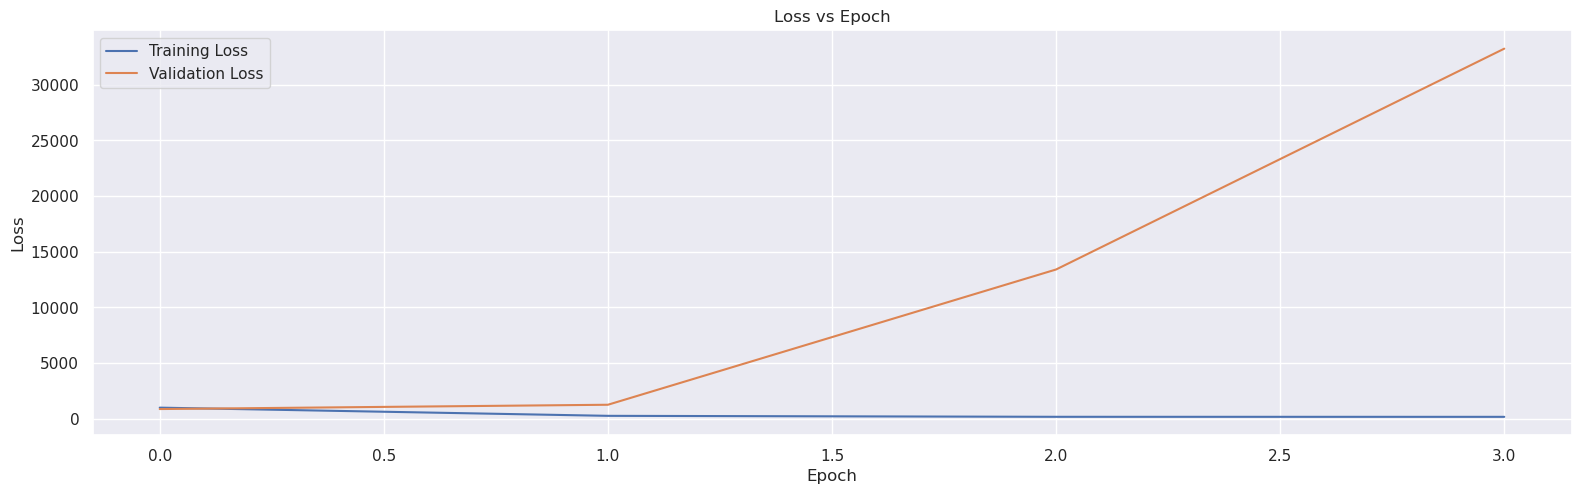

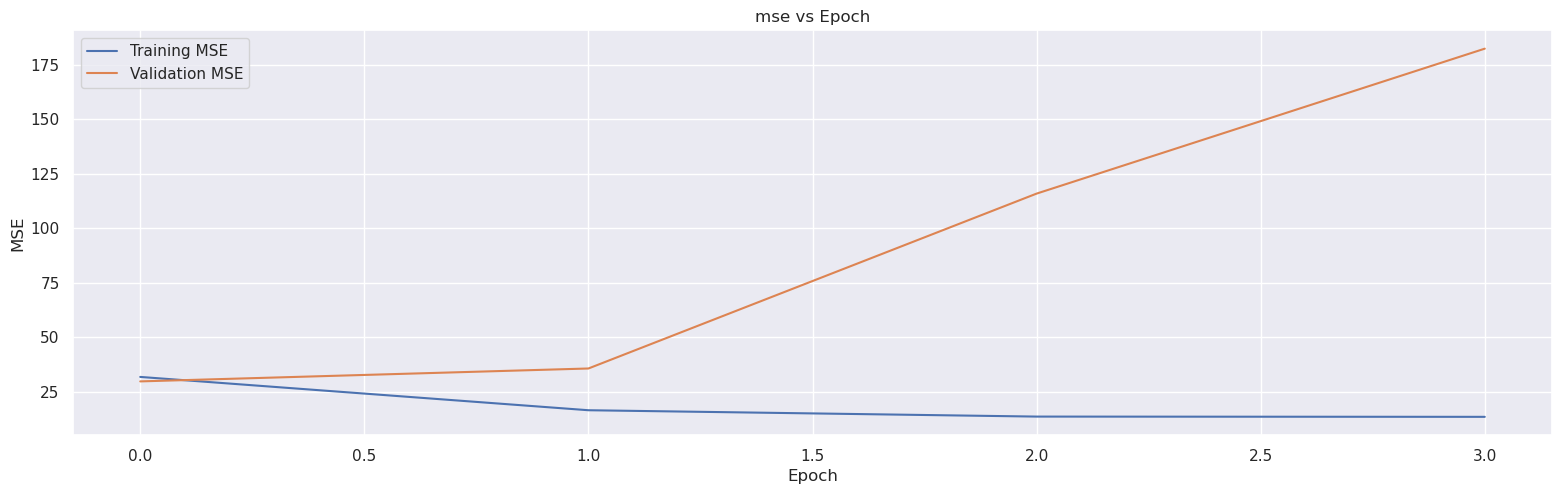

for junction 2:


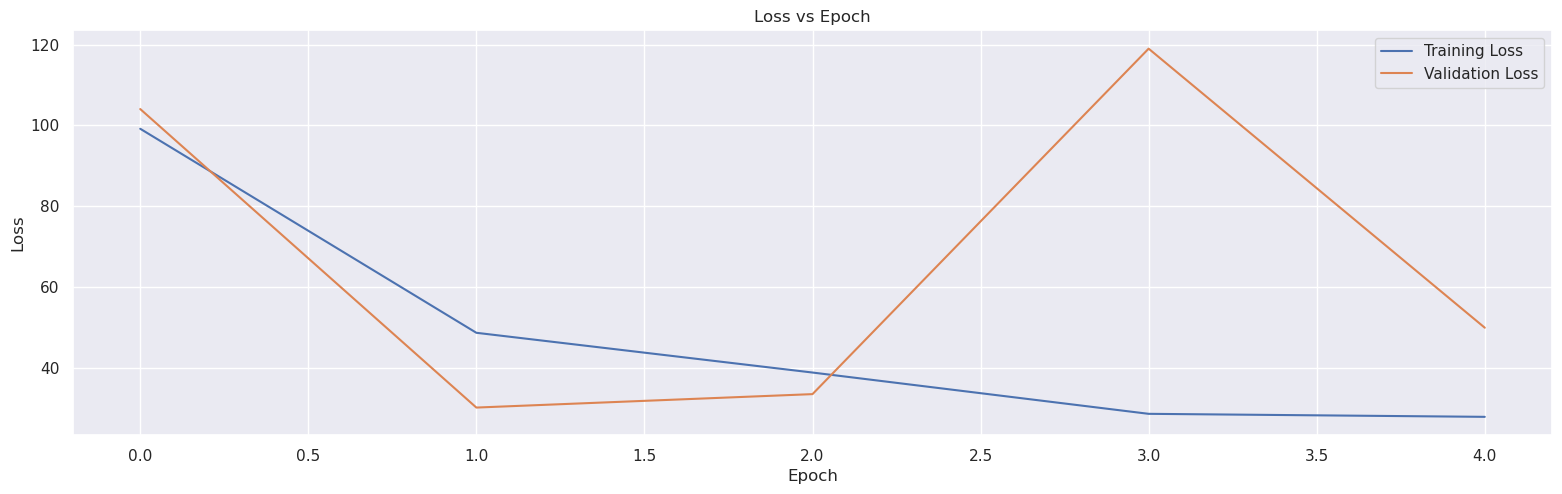

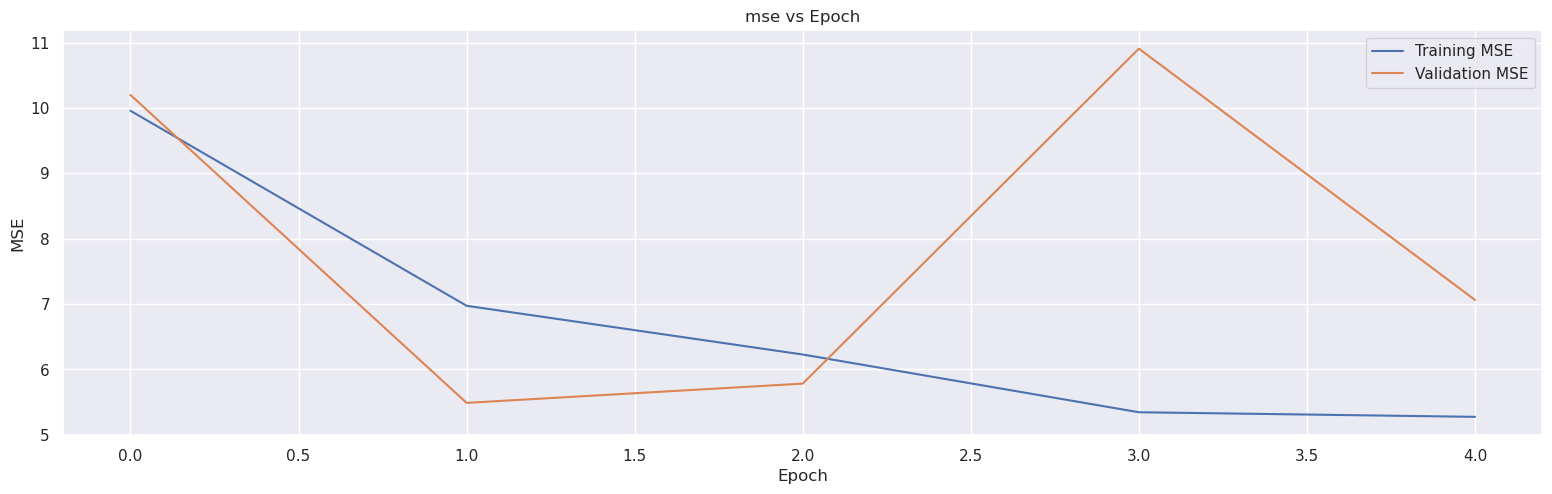

for junction 3:


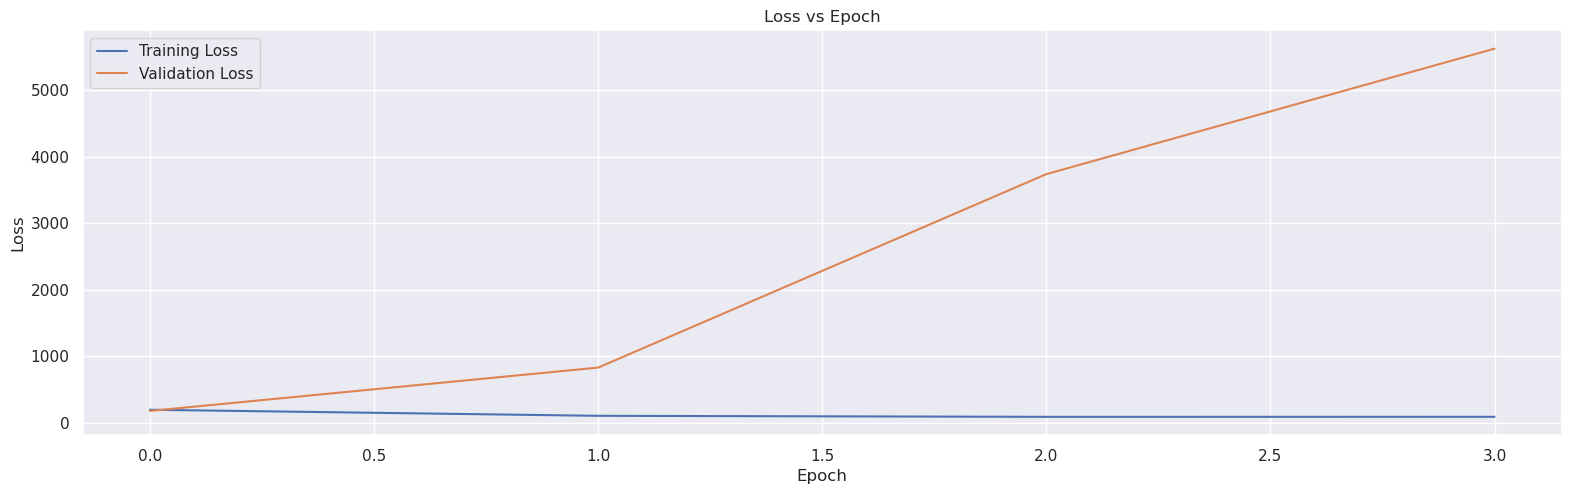

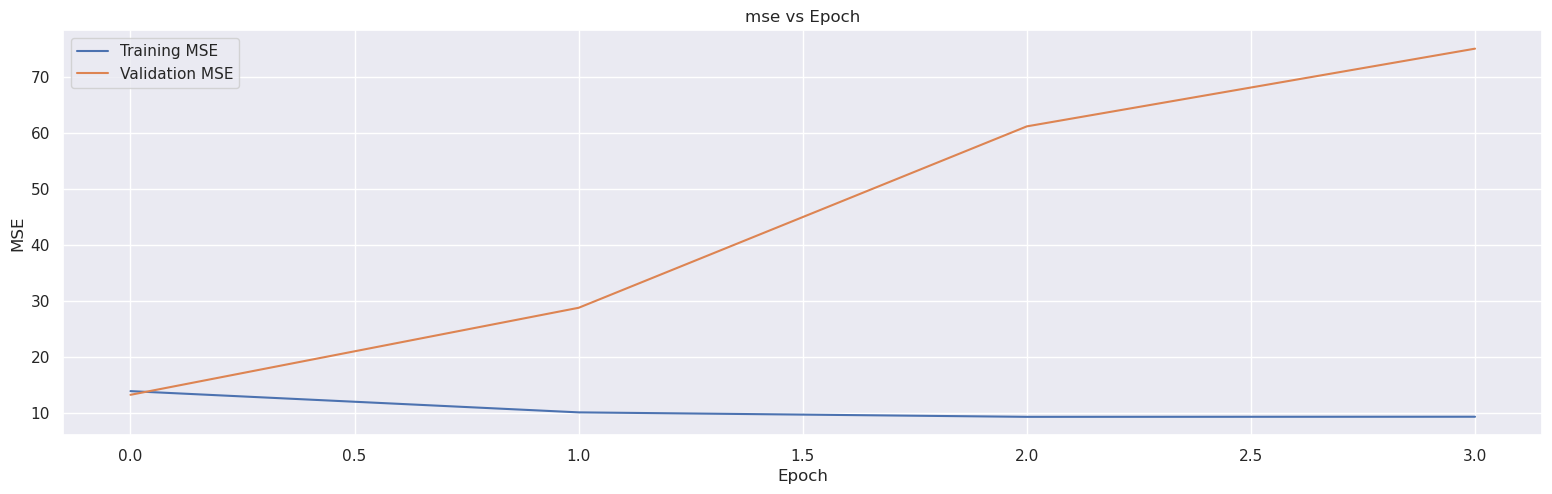

for junction 4:


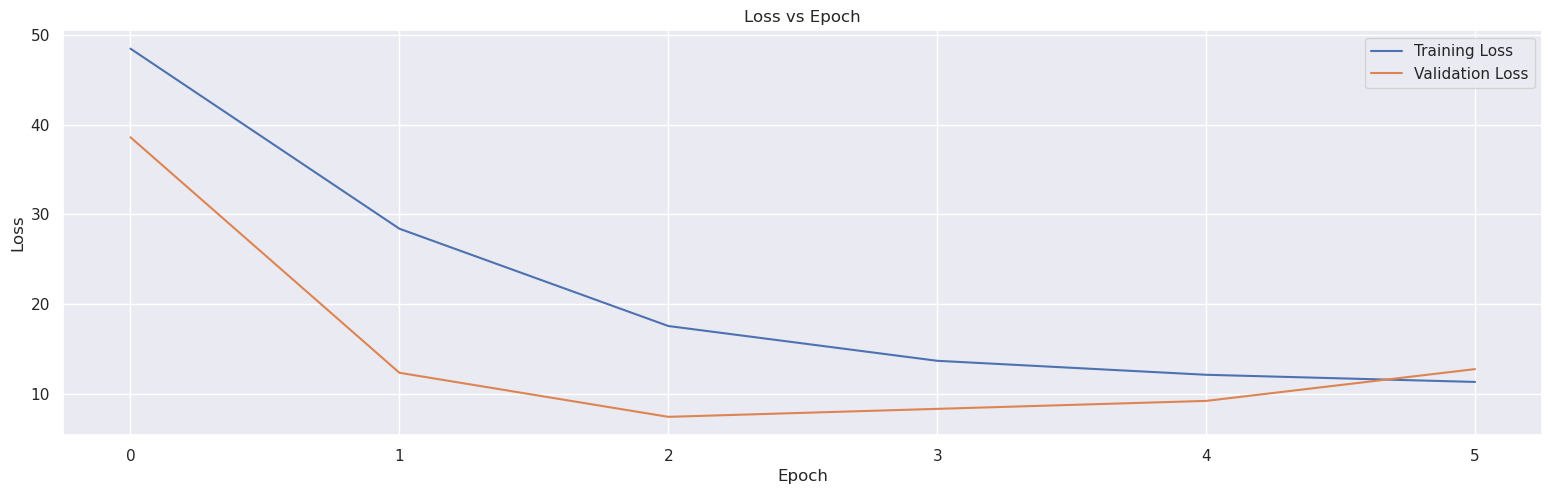

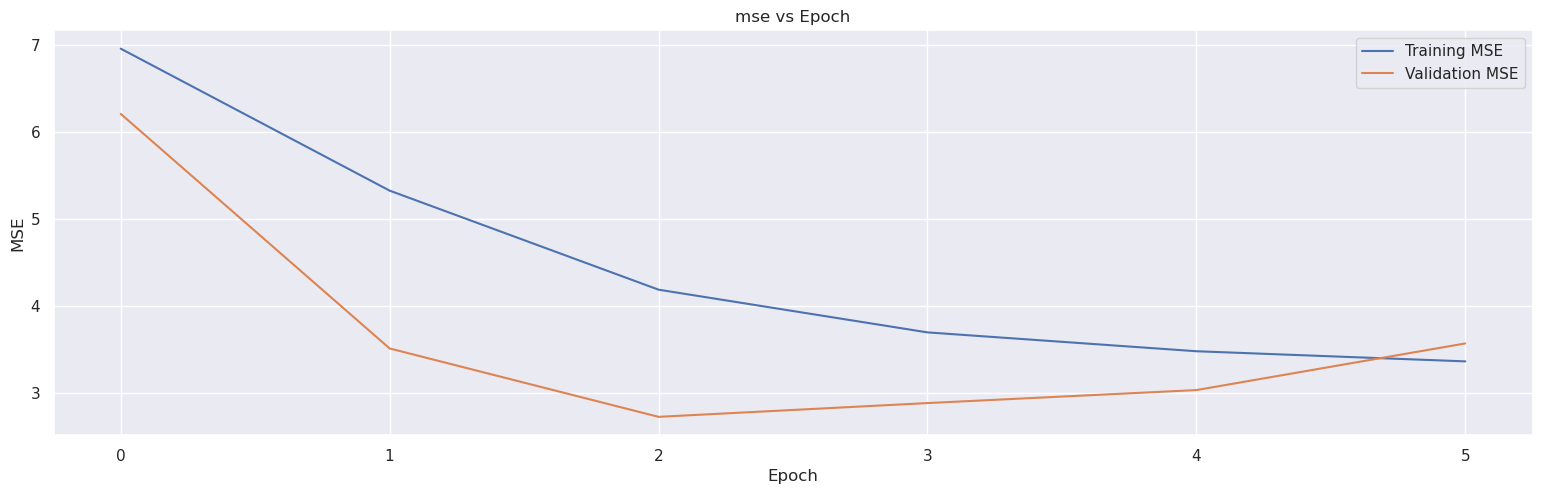

In [141]:
for i in range(1,5):
    print(f"for junction {i}:")
    plt.title('Loss vs Epoch')
    plotting_loss(training_loss[i-1],validation_loss[i-1])
    plt.title('mse vs Epoch')
    plotting_mse(training_mse[i-1],validation_mse[i-1])

for junction 1:


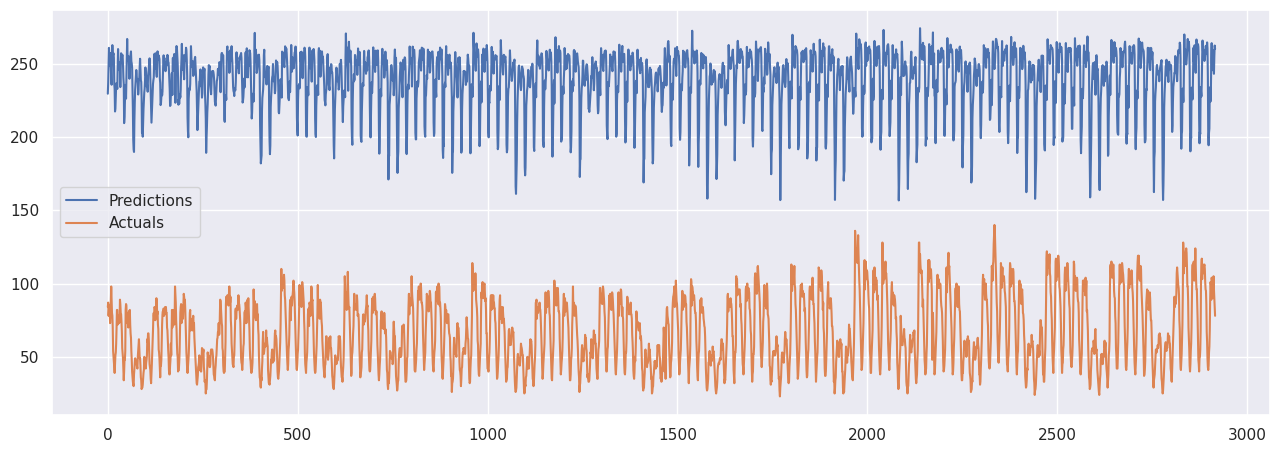

for junction 2:


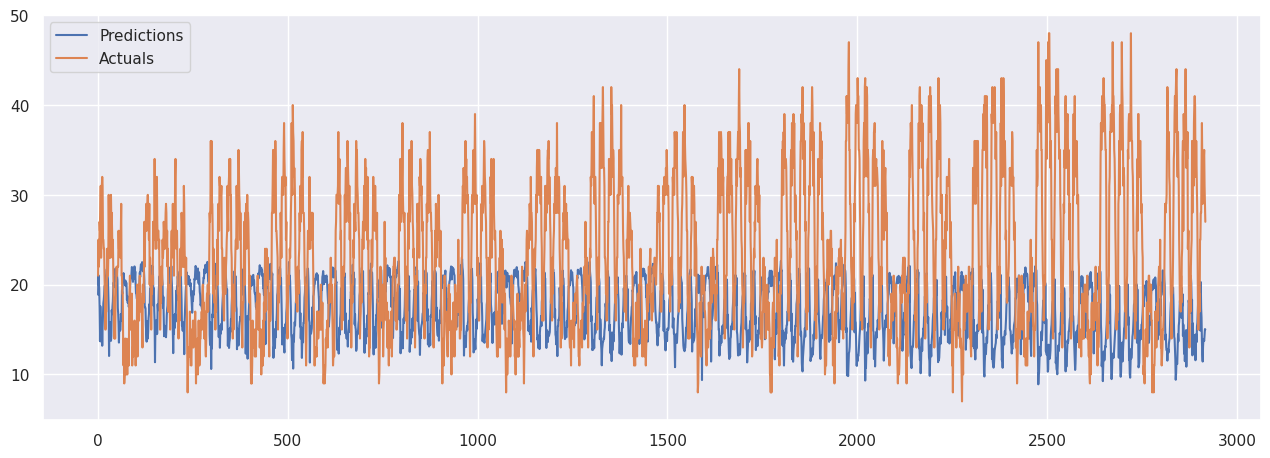

for junction 3:


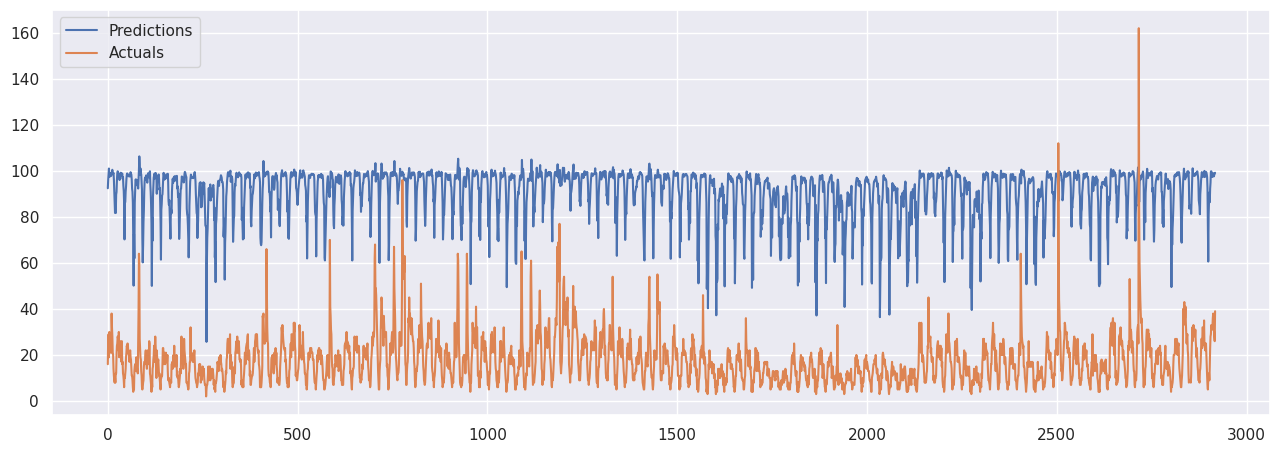

for junction 4:


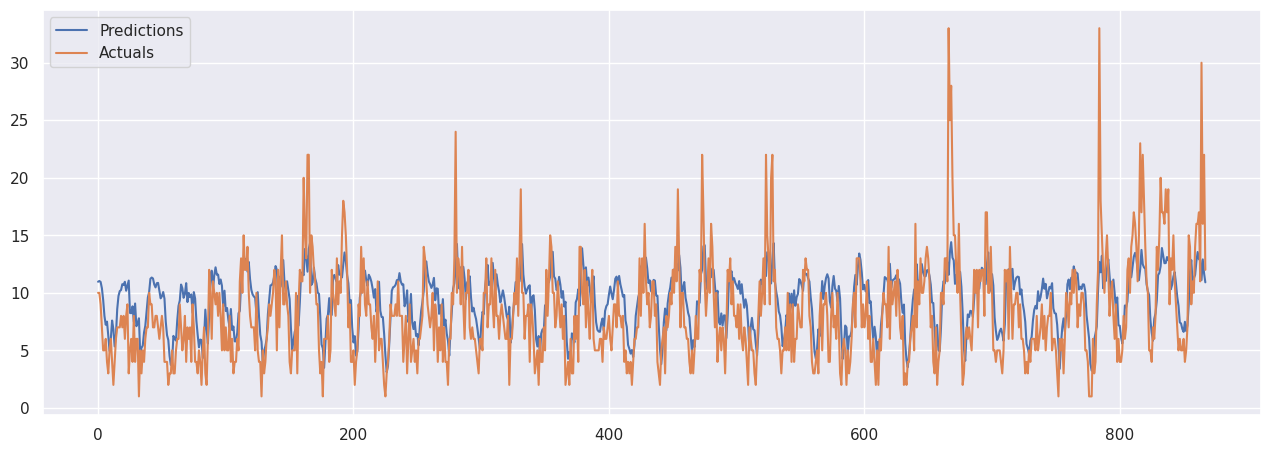

In [142]:
for i in range(1,5):
    print(f"for junction {i}:")
    plot_predictions(test[i-1], prediction[i-1])